In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from os import path
import xarray as xr
from matplotlib.colors import Normalize, LinearSegmentedColormap
from pydicts.obsdict import get_FINO_obs
from mmctools.helper_functions import theta_to_T, lowess_mean, calc_uv
from mmctools.wrf.utils import Tower, tsout_seriesReader, write_tslist_file
from mmctools.helper_functions import calc_wind
import wrf
from netCDF4 import Dataset
from taylorDiagram import TaylorDiagram
import matplotlib.colors as colors
import scipy.stats as stats

# Read in buoy data:

In [3]:
obs_f_dir = '/glade/work/hawbecke/ATEC/Chesapeake/Data/Obs/BUOY/'
obs_type = 'NDBC' # CBIBS or NDBC
obs_dir = '{}{}/'.format(obs_f_dir,obs_type)

buoy_f = '{}buoy_data_res_2019.nc'.format(obs_dir)
obs_ds = xr.open_dataset(buoy_f)

In [4]:
buoy_loc_dict = {}
for stn in obs_ds.station.data:
    buoy_loc_dict[stn] = {'lat':float(obs_ds.sel(station=stn).lat.data),
                     'lon':float(obs_ds.sel(station=stn).lon.data)}



In [5]:
buoy_loc_dict

{'ANN': {'lat': 38.963, 'lon': -76.448},
 'BIS': {'lat': 38.22, 'lon': -76.039},
 'CAM': {'lat': 38.574, 'lon': -76.069},
 'DEB': {'lat': 38.457, 'lon': -74.702},
 'FLG': {'lat': 36.998, 'lon': -76.087},
 'GOO': {'lat': 38.556, 'lon': -76.415},
 'LWT': {'lat': 37.995, 'lon': -76.465},
 'SLM': {'lat': 38.321, 'lon': -76.452},
 'TBL': {'lat': 37.026, 'lon': -76.151},
 'THP': {'lat': 38.899, 'lon': -76.436},
 'VAB': {'lat': 36.601, 'lon': -74.834},
 'WDC': {'lat': 38.873, 'lon': -77.021},
 'YKS': {'lat': 37.201, 'lon': -76.266}}

### Buoys PMC and SRP do not have data for this period

In [6]:
buoy_list = list(buoy_loc_dict.keys())

if obs_type == 'CBIBS':
    buoy_loc_dict['JTN']['lat'] = 37.21137
    buoy_loc_dict['JTN']['lon'] = -76.78677

    buoy_list.remove('PMC')
    buoy_list.remove('SRP')

    buoy_list
elif obs_type == 'NDBC':
    buoy_list.remove('WDC')

# Extract WRF data at buoy locations

### WRF file information:

In [7]:
wrf_dir    = '/glade/scratch/hawbecke/WRF/ATEC/Chesapeake/20190716to20190801/'

cases = ['ERAI_YSU_CHRN_OST_NOSK_4DOM','ERAI_YSU_CHRN_OST_SKNT_3DOM','ERAI_YSU_CHRN_GHR_NOSK_3DOM','ERAI_YSU_CHRN_GHR_SKNT_3DOM',
         'ERAI_YSU_JMNZ_OST_NOSK_3DOM','ERAI_YSU_CHRN_OST_OCEA_3DOM','ERAI_YSU_CHRN_GHR_OCEA_3DOM',
         'ERAI_YSU_CHRN_MOD_NOSK_3DOM','ERAI_YSU_CHRN_MOD_SKNT_3DOM',
         'GFSR_YSU_CHRN_GFS_NOSK_3DOM','GFSR_YSU_CHRN_GHR_NOSK_3DOM','GFSR_YSU_CHRN_GFS_SKNT_3DOM','GFSR_YSU_CHRN_GHR_SKNT_3DOM',
         'GFSR_YSU_CHRN_MOD_NOSK_3DOM','GFSR_YSU_CHRN_MOD_SKNT_3DOM',
         'ERA5_YSU_CHRN_ER5_NOSK_3DOM','ERA5_YSU_CHRN_ER5_SKNT_3DOM','ERA5_YSU_CHRN_ER5_OVER_3DOM','ERA5_YSU_CHRN_ER5_OVSK_3DOM']
ncases   = len(cases)
case_dom = [3]*ncases
#case_dom[1] = 4
#case_dom[2] = 4

restarts   = ['CBB_2019071518', 'CBB_2019071718', 'CBB_2019071918', 'CBB_2019072118', 
              'CBB_2019072318', 'CBB_2019072518', 'CBB_2019072718', 'CBB_2019072918']

wrf_start  = ['2019-07-15 18:00:00','2019-07-17 18:00:00','2019-07-19 18:00:00','2019-07-21 18:00:00',
              '2019-07-23 18:00:00','2019-07-25 18:00:00','2019-07-27 18:00:00','2019-07-29 18:00:00',]


# Load the case dictionary file specifying case names, domains, colors, and markers

In [8]:
from CBB_case_dict import case_dict

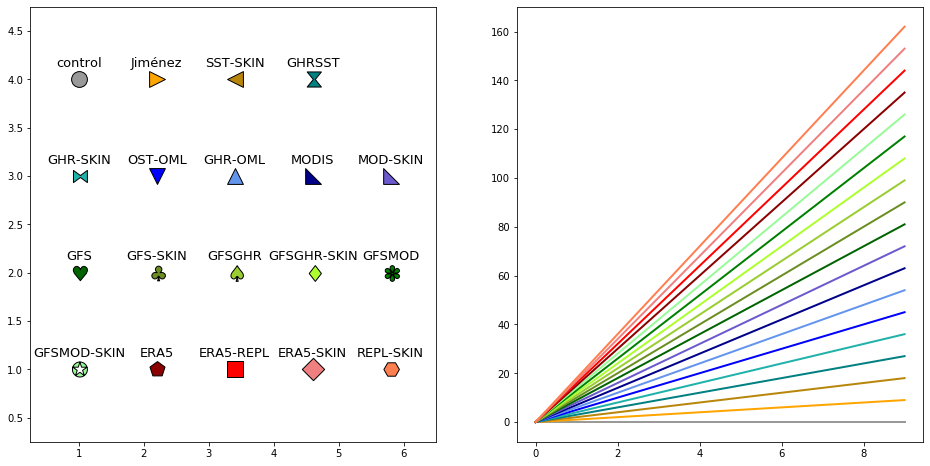

In [11]:
x_p = 1
y_p = 4
x = np.arange(0,10)
count = 0
fig,ax = plt.subplots(figsize=(16,8),ncols=2)
for cc,case in enumerate(case_dict):
    case_d = case_dict[case]
    for dom_d in case_d:
        plt_d = case_d[dom_d]
        
        if plt_d['fill']:
            marker_c = plt_d['color']
            marker_e = 'k'
        else:
            marker_c = plt_d['color']
            marker_c = 'k'
            marker_e = plt_d['color']

        
        #if not plt_d['fill']:
        #    ax[0].scatter(x_p,y_p,c='k',marker=plt_d['marker'],edgecolors='k',lw=3.0,s=150)
        ax[0].scatter(x_p,y_p,c=marker_c,marker=plt_d['marker'],edgecolors=marker_e,s=250,zorder=3)
        ax[0].text(x_p,y_p+0.1,plt_d['name'],ha='center',va='bottom',size=13)
        x_p += 1.2
        if (plt_d['name'] == 'MOD-SKIN') or (plt_d['name'] == 'GHRSST') or (plt_d['name'] == 'GFSMOD'):
            x_p = 1
            y_p -= 1
            
        
        ax[1].plot(x,x*count,c=plt_d['color'],lw=2.0)
        count += 1
ax[0].set_ylim(0.25,4.75)    
ax[0].set_xlim(0.25,6.5)
plt.show()

### Read in WRF output at location of buoys

starting CBB_2019071518


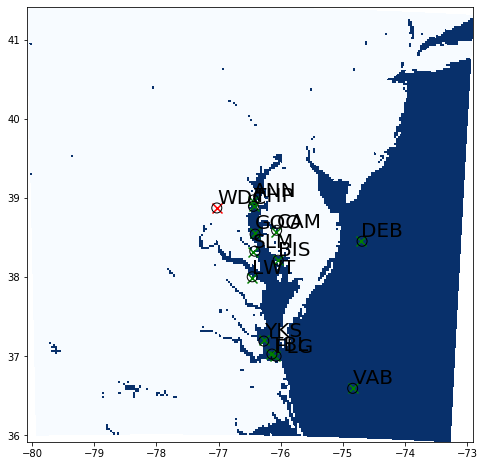

In [10]:
for cc,case in enumerate([cases[4]]):
    fig = plt.figure(figsize=(8,8))
    print('starting {}'.format(restarts[0]))
    f_list = sorted(glob.glob('{}{}/{}/wrfout_d0{}*'.format(wrf_dir,case,restarts[0],case_dom[cc])))

    wrf_loc_dict = {}
    wrf_i = Dataset('{}/wrfinput_d0{}'.format('/'.join(f_list[0].split('/')[:-1]),case_dom[cc]))
    lat = wrf_i.variables['XLAT'][0,:,:]
    lon = wrf_i.variables['XLONG'][0,:,:]
    landmask = wrf_i.variables['LANDMASK'][0,:,:]
    plt.pcolormesh(lon,lat,landmask,cmap=plt.cm.Blues_r)


    for ss,stn in enumerate(buoy_loc_dict):
        wrf_loc_dict[stn] = {}
        loc_x,loc_y = wrf.ll_to_xy(wrf_i,buoy_loc_dict[stn]['lat'],buoy_loc_dict[stn]['lon'])
        loc_x = int(loc_x.data)
        loc_y = int(loc_y.data)
        wrf_loc_dict[stn]['x'] = loc_x
        wrf_loc_dict[stn]['y'] = loc_y
        if obs_type == 'CBIBS':
            if stn == 'ANN':loc_x += 1
        elif obs_type == 'NDBC':
            if stn == 'CAM':loc_y += 1
            if stn == 'SLM':loc_x += 1

        wrf_lat = wrf_i.variables['XLAT'][0,loc_y,loc_x]
        wrf_lon = wrf_i.variables['XLONG'][0,loc_y,loc_x]
        lmask = wrf_i.variables['LANDMASK'][0,loc_y,loc_x]
        lui   = wrf_i.variables['LU_INDEX'][0,loc_y,loc_x]
        wd   = wrf_i.variables['WATER_DEPTH'][0,loc_y,loc_x]
        
        if lmask == 1:
            mc = 'r'
            #print(stn,landmask[loc_y-1:loc_y+2,loc_x-1:loc_x+2])
        else:
            mc = 'g'
        plt.scatter(buoy_loc_dict[stn]['lon'],buoy_loc_dict[stn]['lat'],marker='x',s=100,c=mc)
        plt.scatter(wrf_lon,wrf_lat,marker='o',s=100,c='None',edgecolors='k')
        plt.text(buoy_loc_dict[stn]['lon'],buoy_loc_dict[stn]['lat'],stn,size=20,va='bottom')      
        
    wrf_i.close()
    #plt.ylim(36.5,39.5)
    #plt.xlim(-78.0,-75)
    plt.show()


In [11]:
wrf_buoys = {}
for cc,case in enumerate(cases):
    new_f_name = '{0}{1}/{1}_extracted_{2}_buoy_data_d0{3}.nc'.format(wrf_dir,case,obs_type,case_dom[cc])
    if path.exists('{}'.format(new_f_name)):
        print('Data for {} already created!'.format(new_f_name.split('/')[-1]))
        wrf_buoys['{}_{}'.format(case,'d0{}'.format(case_dom[cc]))] = xr.open_dataset('{}'.format(new_f_name))
    else:
        print(case)
        get_wrf_locs = True
        rst_dict = {}
        for rr,rst in enumerate(restarts):
            print('starting {}'.format(rst))
            f_list = sorted(glob.glob('{}{}/{}/wrfout_d0{}*'.format(wrf_dir,case,rst,case_dom[cc])))

            if get_wrf_locs:
                wrf_loc_dict = {}
                wrf_i = Dataset('{}/wrfinput_d0{}'.format('/'.join(f_list[0].split('/')[:-1]),case_dom[cc]))
                is_water = [True]*len(buoy_loc_dict)
                hgt      = np.zeros(len(buoy_loc_dict))
                for ss,stn in enumerate(buoy_loc_dict):
                    wrf_loc_dict[stn] = {}
                    loc_x,loc_y = wrf.ll_to_xy(wrf_i,buoy_loc_dict[stn]['lat'],buoy_loc_dict[stn]['lon'])
                    loc_x = int(loc_x.data)
                    loc_y = int(loc_y.data)
                    # Some buoy locations are on land... grab the water cell next to it
                    if obs_type == 'CBIBS':
                        if stn == 'ANN':loc_x += 1
                    elif obs_type == 'NDBC':
                        if stn == 'CAM':loc_y += 1
                        if stn == 'SLM':loc_x += 1

                    #print(loc_x,loc_y)
                    wrf_loc_dict[stn]['x'] = loc_x
                    wrf_loc_dict[stn]['y'] = loc_y
                    #print(wrf_loc_dict[stn])
                    # Check WRF is grabbing right locations:
                    wrf_lat = wrf_i.variables['XLAT'][0,loc_y,loc_x]
                    wrf_lon = wrf_i.variables['XLONG'][0,loc_y,loc_x]
                    landmask = wrf_i.variables['LANDMASK'][0,loc_y,loc_x]
                    hgt[ss]  = wrf_i.variables['HGT'][0,loc_y,loc_x]
                    if landmask == 1:
                        is_water[ss] = False
                get_wrf_locs = False
                wrf_i.close()
            wrf_times = []

            wspd = np.zeros((len(f_list),len(buoy_loc_dict)))
            wdir = np.zeros((len(f_list),len(buoy_loc_dict)))
            t2   = np.zeros((len(f_list),len(buoy_loc_dict)))
            tsk  = np.zeros((len(f_list),len(buoy_loc_dict)))
            sst  = np.zeros((len(f_list),len(buoy_loc_dict)))
            

            for ff,fname in enumerate(f_list):
                wrf_f = Dataset(fname)
                wrf_times.append(wrf.extract_times(wrf_f,timeidx=0))
                for ss,stn in enumerate(buoy_loc_dict):
                    u10 = wrf_f.variables['U10'][0,wrf_loc_dict[stn]['y'],wrf_loc_dict[stn]['x']]
                    v10 = wrf_f.variables['V10'][0,wrf_loc_dict[stn]['y'],wrf_loc_dict[stn]['x']]

                    wspd[ff,ss] = (u10**2 + v10**2)**0.5
                    wdir[ff,ss] = 180. + np.degrees(np.arctan2(u10, v10))
                    t2[ff,ss]   = wrf_f.variables['T2'][0,wrf_loc_dict[stn]['y'],wrf_loc_dict[stn]['x']]
                    tsk[ff,ss]  = wrf_f.variables['TSK'][0,wrf_loc_dict[stn]['y'],wrf_loc_dict[stn]['x']]
                    try:
                        sst[ff,ss]  = wrf_f.variables['SST'][0,wrf_loc_dict[stn]['y'],wrf_loc_dict[stn]['x']]
                    except KeyError:
                        if ff == 0 and ss == 0: print('no SST data found... setting to zero')
                        sst[ff,ss] = tsk[ff,ss]*0.0
                    

                wrf_f.close()
            rst_dict[rst] = xr.Dataset({'wspd': (['datetime','station'],wspd),
                                        'wdir': (['datetime','station'],wdir),
                                        't2'  : (['datetime','station'],t2),
                                        'tsk' : (['datetime','station'],tsk),
                                        'sst' : (['datetime','station'],sst),
                                    'is_water': (['station'],is_water),
                                         'hgt': (['station'],hgt)},
                                        coords={'datetime':wrf_times,
                                                'station': list(buoy_loc_dict.keys())})             
            if rr == 0:
                full_ds = rst_dict[rst]
            else:
                full_ds = full_ds.combine_first(rst_dict[rst])

        full_ds.to_netcdf(new_f_name)
        wrf_buoys['{}_{}'.format(case,'d0{}'.format(case_dom[cc]))]  = full_ds


        fig = plt.figure(figsize=(18,6))
        full_ds.sel(station='ANN').wspd.plot(lw=2.0,c='k')
        for rr,rst in enumerate(rst_dict):
            rst_dict[rst].sel(station='ANN').wspd.plot(lw=1.0)
        plt.show()
        


Data for ERAI_YSU_CHRN_OST_NOSK_4DOM_extracted_NDBC_buoy_data_d03.nc already created!
Data for ERAI_YSU_CHRN_OST_SKNT_3DOM_extracted_NDBC_buoy_data_d03.nc already created!
Data for ERAI_YSU_CHRN_GHR_NOSK_3DOM_extracted_NDBC_buoy_data_d03.nc already created!
Data for ERAI_YSU_CHRN_GHR_SKNT_3DOM_extracted_NDBC_buoy_data_d03.nc already created!
Data for ERAI_YSU_JMNZ_OST_NOSK_3DOM_extracted_NDBC_buoy_data_d03.nc already created!
Data for ERAI_YSU_CHRN_OST_OCEA_3DOM_extracted_NDBC_buoy_data_d03.nc already created!
Data for ERAI_YSU_CHRN_GHR_OCEA_3DOM_extracted_NDBC_buoy_data_d03.nc already created!
Data for GFSR_YSU_CHRN_GFS_NOSK_3DOM_extracted_NDBC_buoy_data_d03.nc already created!
Data for GFSR_YSU_CHRN_GHR_NOSK_3DOM_extracted_NDBC_buoy_data_d03.nc already created!
Data for GFSR_YSU_CHRN_GFS_SKNT_3DOM_extracted_NDBC_buoy_data_d03.nc already created!
Data for GFSR_YSU_CHRN_GHR_SKNT_3DOM_extracted_NDBC_buoy_data_d03.nc already created!
Data for ERA5_YSU_CHRN_ER5_NOSK_3DOM_extracted_NDBC_bu

In [12]:
t_s = wrf_buoys['{}_{}'.format(cases[0],'d0{}'.format(case_dom[0]))].datetime.data[0] + pd.to_timedelta(12,'h') - pd.to_timedelta(3,'s') # Account for spinup
t_e = wrf_buoys['{}_{}'.format(cases[0],'d0{}'.format(case_dom[0]))].datetime.data[-1]

In [13]:
for case in wrf_buoys:
    print(case)
    for stn in buoy_loc_dict:
        is_water = wrf_buoys[case].sel(station=stn).is_water.data
        #if not is_water and stn in buoy_list:
        if not is_water:
            print('{} is on land'.format(stn))
    print('')
#buoy_list.remove('ANN')

ERAI_YSU_CHRN_OST_NOSK_4DOM_d03
WDC is on land

ERAI_YSU_CHRN_OST_SKNT_3DOM_d03
WDC is on land

ERAI_YSU_CHRN_GHR_NOSK_3DOM_d03
WDC is on land

ERAI_YSU_CHRN_GHR_SKNT_3DOM_d03
WDC is on land

ERAI_YSU_JMNZ_OST_NOSK_3DOM_d03
WDC is on land

ERAI_YSU_CHRN_OST_OCEA_3DOM_d03
WDC is on land

ERAI_YSU_CHRN_GHR_OCEA_3DOM_d03
WDC is on land

GFSR_YSU_CHRN_GFS_NOSK_3DOM_d03
WDC is on land

GFSR_YSU_CHRN_GHR_NOSK_3DOM_d03
WDC is on land

GFSR_YSU_CHRN_GFS_SKNT_3DOM_d03
WDC is on land

GFSR_YSU_CHRN_GHR_SKNT_3DOM_d03
WDC is on land

ERA5_YSU_CHRN_ER5_NOSK_3DOM_d03
WDC is on land

ERA5_YSU_CHRN_ER5_SKNT_3DOM_d03
WDC is on land

ERA5_YSU_CHRN_ER5_OVER_3DOM_d03
WDC is on land

ERA5_YSU_CHRN_ER5_OVSK_3DOM_d03
WDC is on land



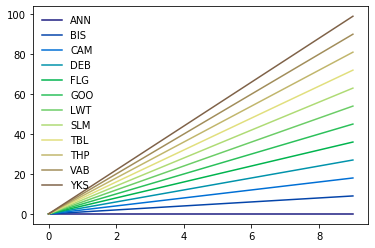

In [14]:
stn_colors = {}
for ss,stn in enumerate(buoy_list):
    line_cols = plt.cm.terrain(np.linspace(0.0,0.7,len(buoy_list)))[ss]
    darken = 0.1
    for tt,col in enumerate(line_cols):
        if tt < 3:
            line_cols[tt] = col - darken
            if line_cols[tt] < 0.0: line_cols[tt] = 0.0
    stn_colors[stn] = line_cols
for ss,stn in enumerate(buoy_list):
    plt.plot(np.arange(0,10),np.arange(0,10)*ss,c=stn_colors[stn],label=stn)
plt.legend(frameon=False)
plt.show()

# Resample obs and WRF to common times:

### FLN has some erroneous data that can be removed:

In [15]:
if obs_type == 'CBIBS':
    temp_obs = obs_ds.temp.copy()
    obs_ds = obs_ds.drop_vars('temp')

    fln = temp_obs.sel(station='FLN')
    fln.sel(datetime=slice(t_s,t_e)).dropna(how='all',dim='datetime').plot()

    rem_starts = ['2019-07-23 18:00:00','2019-07-27 00:00:00']
    rem_ends  = ['2019-07-26 12:00:00','2019-07-27 01:45:00']


    for rem_s,rem_e in zip(rem_starts,rem_ends):
        fln.sel(datetime=slice(rem_s,rem_e)).data[:] = fln.sel(datetime=slice(rem_s,rem_e)).data[:]*np.nan

    fln.sel(datetime=slice(t_s,t_e)).dropna(how='all',dim='datetime').plot(marker='o')

    temp_obs.sel(station='FLN').data = fln.data

    temp_obs.sel(station='FLN').sel(datetime=slice(t_s,t_e)).dropna(how='all',dim='datetime').plot(c='g')
    obs_ds['temp'] = temp_obs

    obs_ds.sel(station='FLN').sel(datetime=slice(t_s,t_e)).temp.dropna(how='all',dim='datetime').plot(c='b',ls=':')
    plt.show()

# Calculate u and v for histograms/scatter plots

In [16]:
obs_ds['u'],obs_ds['v'] = calc_uv(obs_ds)

for cc,case in enumerate(wrf_buoys):
    wrf_buoys[case]['u'],wrf_buoys[case]['v'] = calc_uv(wrf_buoys[case])


# Which variables are going to be compared:

In [44]:
vars_to_compare = { 'sst':'tsk',
                   'temp':'t2',
                   'wspd':'wspd'}#,
                   #'wdir':'wdir',
                   #   'u':'u',
                   #   'v':'v'}

In [45]:
def resample_model_output(stn_ds,obs_ds,var_dict,adjustments=None,select_stations=None):
    for vv,var in enumerate(var_dict):
        obs_var = var
        stn_var = var_dict[var]

        temp_ds = stn_ds.copy()
        temp_ds.drop_vars(stn_var)
        temp_var = stn_ds[stn_var].copy()
        if adjustments is not None and len(adjustments) == len(var_dict):
            adjustment = adjustments[vv]
            if adjustment is not None:
                print('Adjusting {} by {}'.format(var,adjustment))
                if adjustment[0] == '+' or adjustment[0] == '-':
                    temp_var += float(adjustment)
                elif adjustment[0] == '*':
                    temp_var = temp_var*float(adjustment[1:])
                elif adjustment[0] == '/':
                    temp_var = temp_var/float(adjustment[1:])
                else:
                    print('adjustment {} not understood. Please use +, -, *, or /'.format(adjustments))
        if select_stations is not None:
            station_list = select_stations
        else:
            station_list = stn_ds.station.data
        for ss,stn in enumerate(station_list):
            if type(obs_ds) == dict:
                obs = obs_ds[stn]
            elif type(obs_ds) == xr.core.dataset.Dataset:
                obs = obs_ds.sel(station=stn)
            else:
                'Need to figure out data type of obs_ds'
            var = temp_var.sel(station=stn)
            
            var[np.where(np.isnan(obs[obs_var].data))] = var[np.where(np.isnan(obs[obs_var].data))]*np.nan

            temp_var.sel(station=stn).data = var.data

        stn_ds[stn_var] = temp_var
    return(stn_ds)

In [60]:
obs_res = obs_ds.copy().sel(datetime=slice(t_s,t_e))
obs_res = obs_res.resample(datetime='1h').nearest(tolerance='15m')

wrf_buoys_res = {}
for cc,case in enumerate(wrf_buoys):
    print(case)
    wrf_buoys_res[case] = resample_model_output(wrf_buoys[case].copy().sel(datetime=slice(t_s,t_e)),
                                                obs_res,var_dict=vars_to_compare,
                                                adjustments=['-273.15','-273.15',None])#,None,None,None])
    

ERAI_YSU_CHRN_OST_NOSK_4DOM_d03
Adjusting sst by -273.15
Adjusting temp by -273.15
ERAI_YSU_CHRN_OST_SKNT_3DOM_d03
Adjusting sst by -273.15
Adjusting temp by -273.15
ERAI_YSU_CHRN_GHR_NOSK_3DOM_d03
Adjusting sst by -273.15
Adjusting temp by -273.15
ERAI_YSU_CHRN_GHR_SKNT_3DOM_d03
Adjusting sst by -273.15
Adjusting temp by -273.15
ERAI_YSU_JMNZ_OST_NOSK_3DOM_d03
Adjusting sst by -273.15
Adjusting temp by -273.15
ERAI_YSU_CHRN_OST_OCEA_3DOM_d03
Adjusting sst by -273.15
Adjusting temp by -273.15
ERAI_YSU_CHRN_GHR_OCEA_3DOM_d03
Adjusting sst by -273.15
Adjusting temp by -273.15
GFSR_YSU_CHRN_GFS_NOSK_3DOM_d03
Adjusting sst by -273.15
Adjusting temp by -273.15
GFSR_YSU_CHRN_GHR_NOSK_3DOM_d03
Adjusting sst by -273.15
Adjusting temp by -273.15
GFSR_YSU_CHRN_GFS_SKNT_3DOM_d03
Adjusting sst by -273.15
Adjusting temp by -273.15
GFSR_YSU_CHRN_GHR_SKNT_3DOM_d03
Adjusting sst by -273.15
Adjusting temp by -273.15
ERA5_YSU_CHRN_ER5_NOSK_3DOM_d03
Adjusting sst by -273.15
Adjusting temp by -273.15
ERA5

In [89]:
cases_of_interest = cases.copy()
doms_of_interest = case_dom.copy()

cases_of_interest = [
                     'ERAI_YSU_CHRN_OST_NOSK_4DOM',
                     'ERAI_YSU_CHRN_OST_SKNT_3DOM',
                     'ERAI_YSU_CHRN_GHR_NOSK_3DOM',
                     'ERAI_YSU_CHRN_GHR_SKNT_3DOM',
                     'ERAI_YSU_JMNZ_OST_NOSK_3DOM',
                     'ERAI_YSU_CHRN_OST_OCEA_3DOM',
                     'ERAI_YSU_CHRN_GHR_OCEA_3DOM',
                     'GFSR_YSU_CHRN_GFS_NOSK_3DOM',
                     'GFSR_YSU_CHRN_GFS_SKNT_3DOM',
                     'GFSR_YSU_CHRN_GHR_NOSK_3DOM',
                     'GFSR_YSU_CHRN_GHR_SKNT_3DOM',
                     'ERA5_YSU_CHRN_ER5_NOSK_3DOM',
                     'ERA5_YSU_CHRN_ER5_SKNT_3DOM',
                     'ERA5_YSU_CHRN_ER5_OVER_3DOM',
                     'ERA5_YSU_CHRN_ER5_OVSK_3DOM'
                    ]
doms_of_interest  = [3]*len(cases_of_interest)

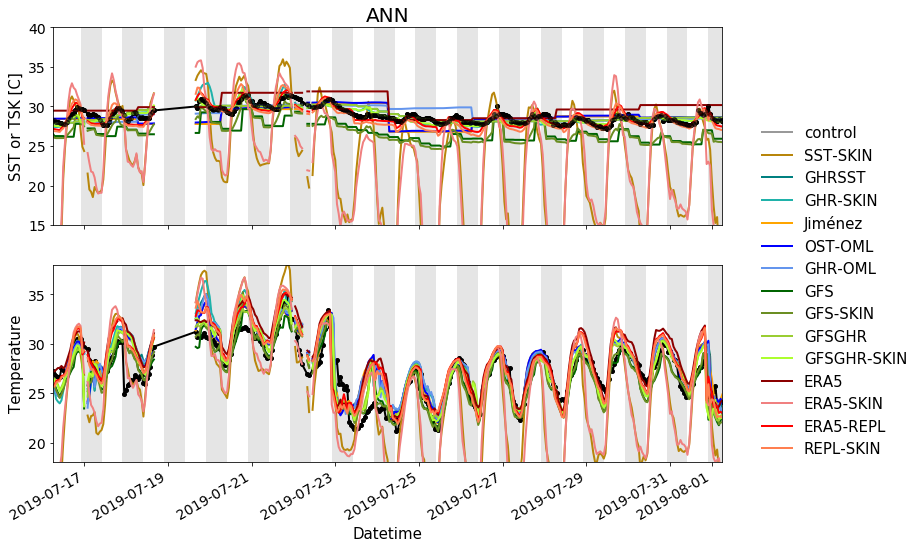

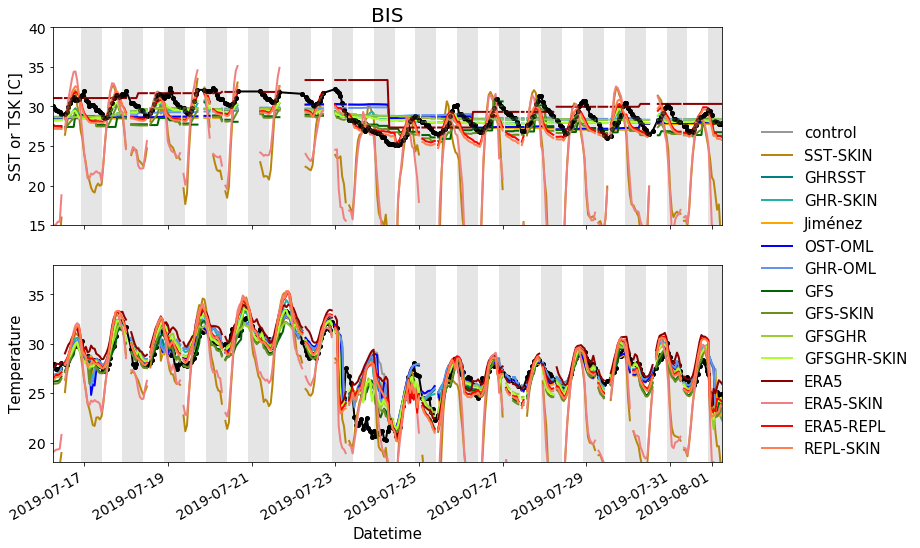

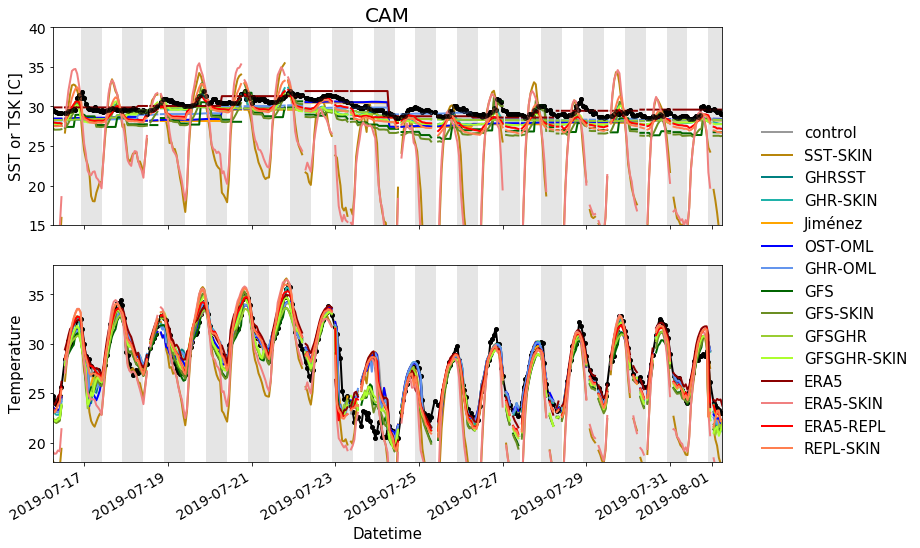

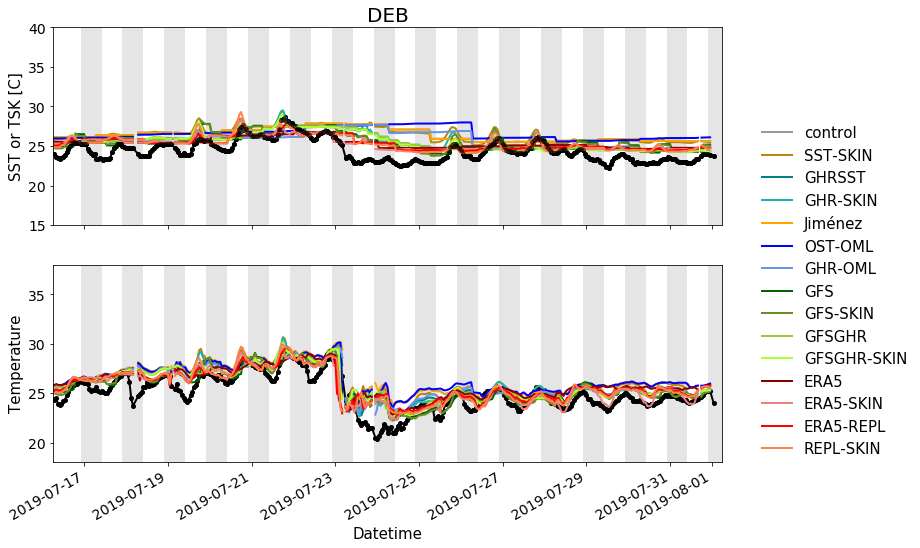

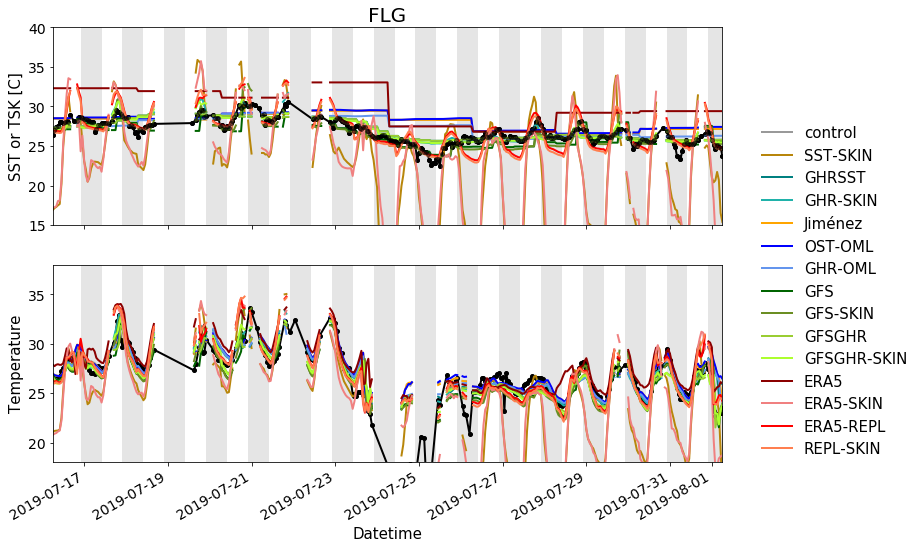

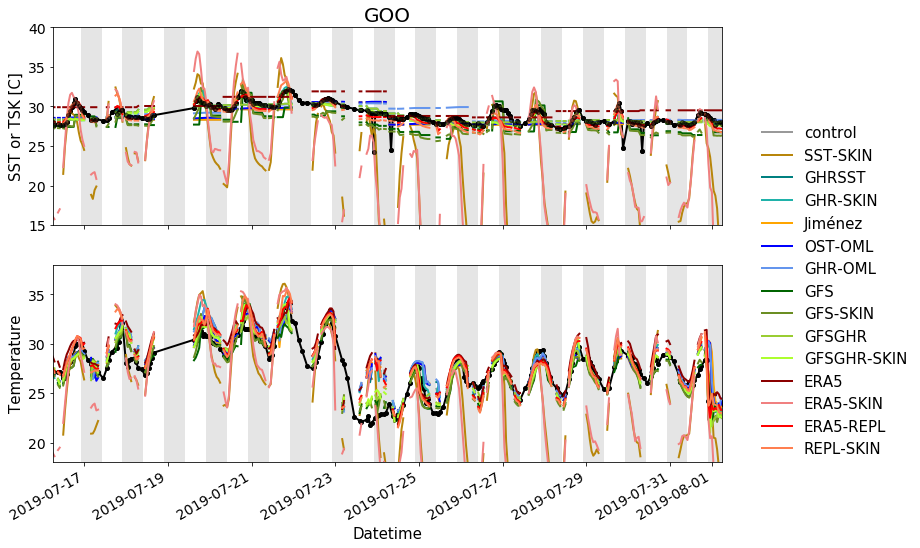

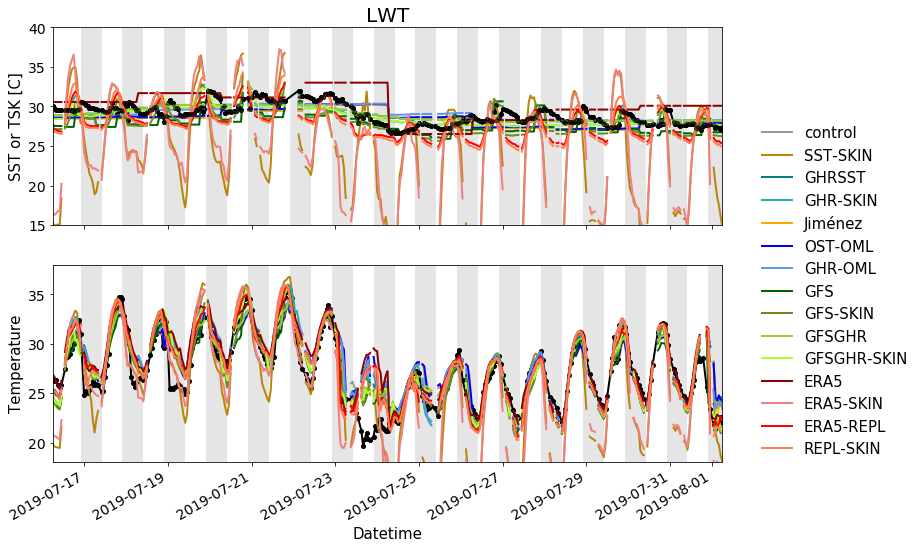

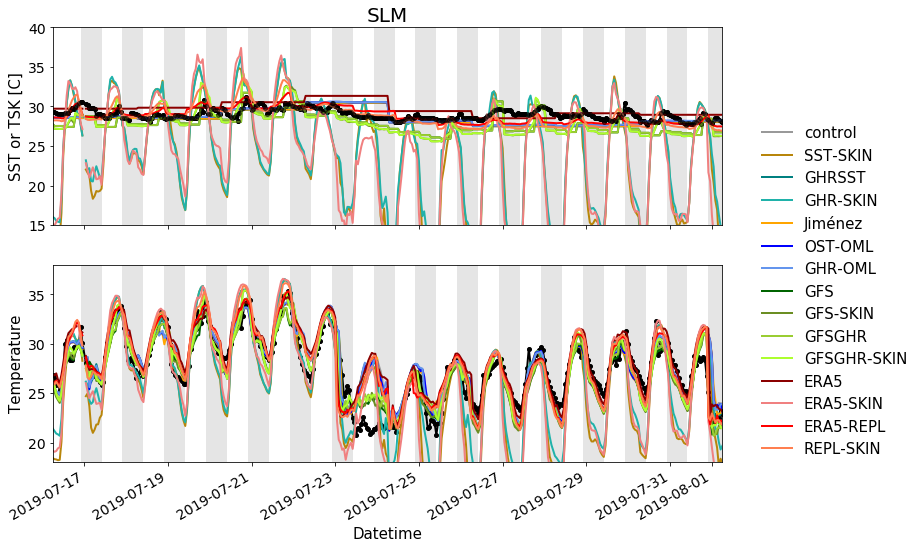

/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN axis encountered
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: All-NaN axis encountered
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN axis encountered
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: All-NaN axis encountered
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN axis encountered
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: All-NaN axis encountered
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN axis encountered
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/ipy

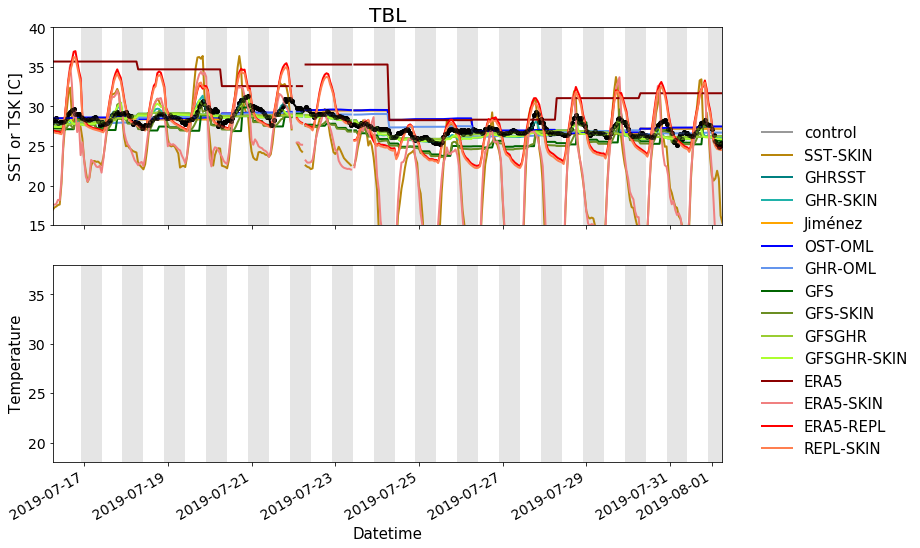

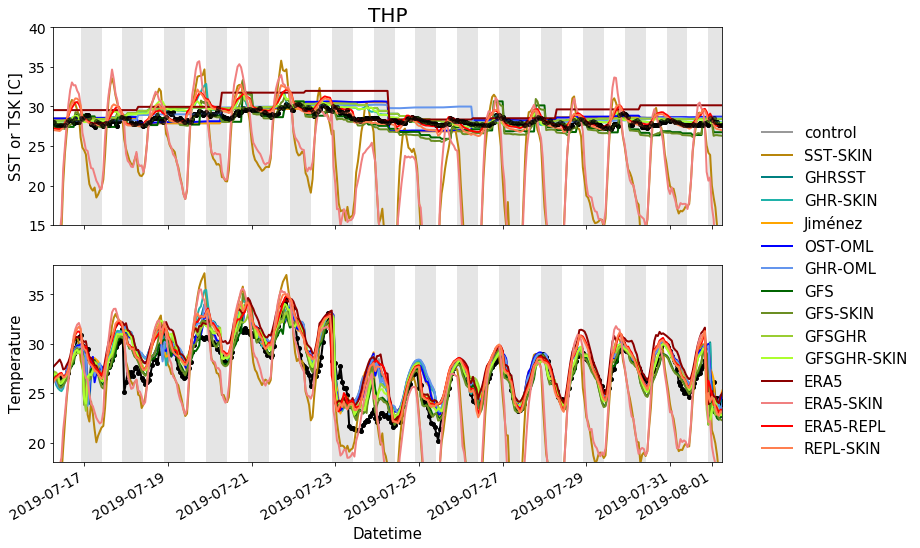

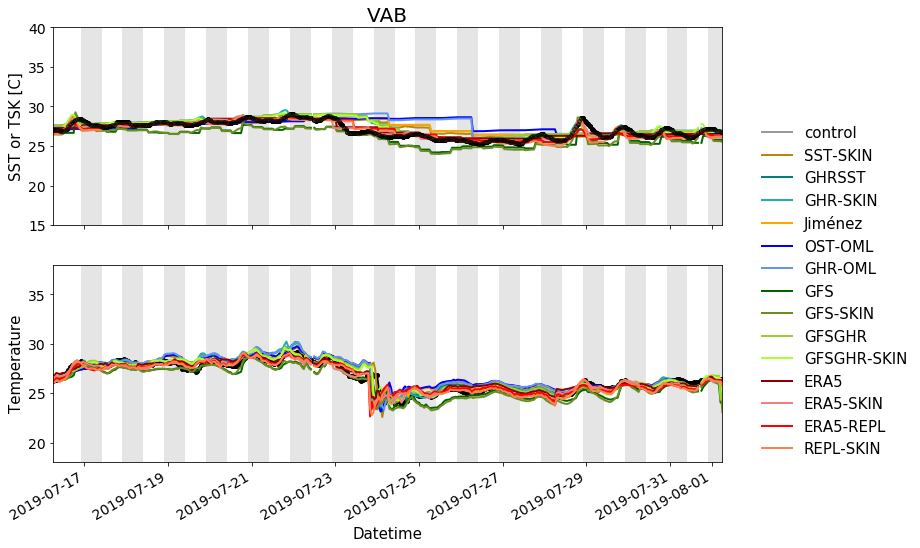

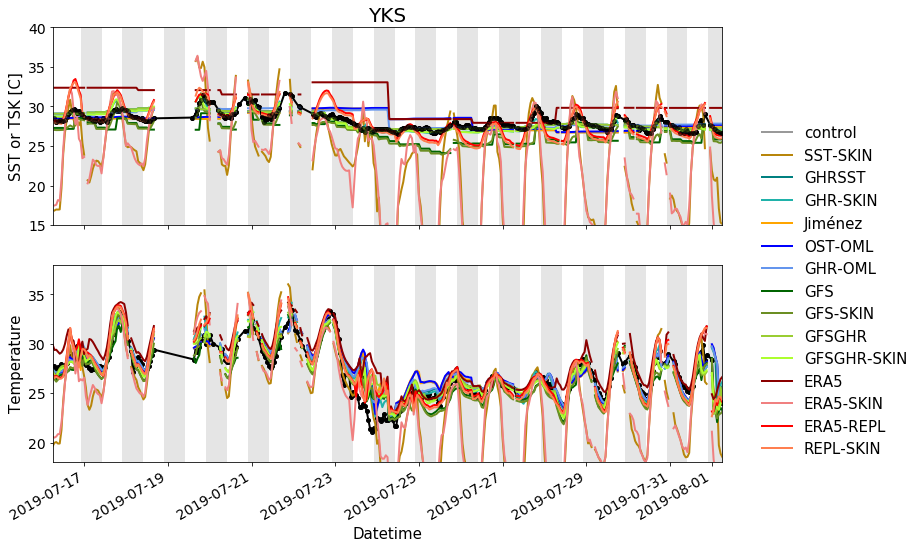

In [90]:
for ss,stn in enumerate(buoy_list):
    fig,ax = plt.subplots(nrows=2,figsize=(12,8),sharex=True)

    sst_obs = obs_res.sel(station=stn).sst.dropna(how='all',dim='datetime')
    if len(sst_obs) > 1:
        sst_obs.plot(ax=ax[0],lw=0.0,c='k',marker='o',markersize=4,zorder=3,alpha=0.5)
        sst_obs.plot(ax=ax[0],lw=2.0,c='k',marker='o',markersize=4)
    
    temp_obs = obs_res.sel(station=stn).temp.dropna(how='all',dim='datetime')
    if len(temp_obs) > 1:
        temp_obs.plot(ax=ax[1],lw=2.0,c='k',marker='o',markersize=4)
        max_t = np.nanmax(temp_obs)
        min_t = np.nanmin(temp_obs)
    else:
        max_t = 40
        min_t = 10
   
    for cc,case in enumerate(cases_of_interest):

        stn_ds = wrf_buoys_res['{}_{}'.format(case,'d0{}'.format(doms_of_interest[cc]))].sel(station=stn)
        case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]

        # ============================================= #
        # ============= SST PLOT =============== #
        sst_wrf = stn_ds.tsk
        sst_wrf.plot(ax=ax[0],label='{}'.format(case_plt_dict['name']),
                      c=case_plt_dict['color'],lw=2.0)#,ls=case_style[cc])
        
        
        # ============================================= #
        # ============ TEMPERATURE PLOT =============== #
        temp_wrf = stn_ds.t2
        temp_wrf.plot(ax=ax[1],label='{}'.format(case_plt_dict['name']),
                      c=case_plt_dict['color'],lw=2.0)#,ls=case_style[cc])
        
        max_t0 = np.nanmax(temp_wrf)
        min_t0 = np.nanmin(temp_wrf)

        if max_t0 > max_t: max_t = max_t0
        if min_t0 < min_t: min_t = min_t0
    try:
        if np.nanmax(temp_obs) > max_t: max_t = np.nanmax(temp_obs)
    except:
        max_t = max_t
    # ----------- SST Adjustments ------------ #
    
    plt_start_date = pd.to_datetime(obs_res.datetime.values[0])
    plt_end_date = pd.to_datetime(obs_res.datetime.values[-1])
    for day in pd.date_range(start=plt_start_date, end=plt_end_date):
        night_s = pd.to_datetime('{}-{}-{} 22:00'.format(day.year,day.month,day.day))
        night_e = pd.to_datetime('{}-{}-{} 10:00'.format(day.year,day.month,day.day)) + pd.Timedelta(1,'d')
        for axi in range(0,2):
            #print('start: {}, end: {}'.format(night_s,night_e))
            ax[axi].fill_betweenx([-100,400],night_s,night_e,facecolor='k',alpha=0.1)
    #ax[0].axhline(5.0,t_s,t_e)
    ax[1].legend(frameon=False,fontsize=15,loc=[1.05,0.0],ncol=1)

    #ax[0].axhline(1.5,0,13,c='k',alpha=0.25)
    ax[0].set_title(stn,size=20)
    ax[0].set_xlabel('')
    ax[0].tick_params(labelsize=14)
    ax[0].set_ylabel('SST or TSK [C]',size=15)
    ax[0].set_ylim(15,40)
    ax[0].set_xlim(t_s,t_e)
    leg_loc = 0.89


    # --------- Temperature Adjustments --------- #
    #ax[2].set_ylim(0,360)
    ax[1].set_xlim(obs_res.datetime.values[0],obs_res.datetime.values[-1])
    ax[1].set_title('')
    ax[1].tick_params(labelsize=14)
    ax[1].set_ylabel('Temperature',size=15)
    ax[1].set_xlabel('Datetime',size=15)
    ax[1].set_ylim(18,38)
    # -------------------------------------------- #
    plt.show()
    

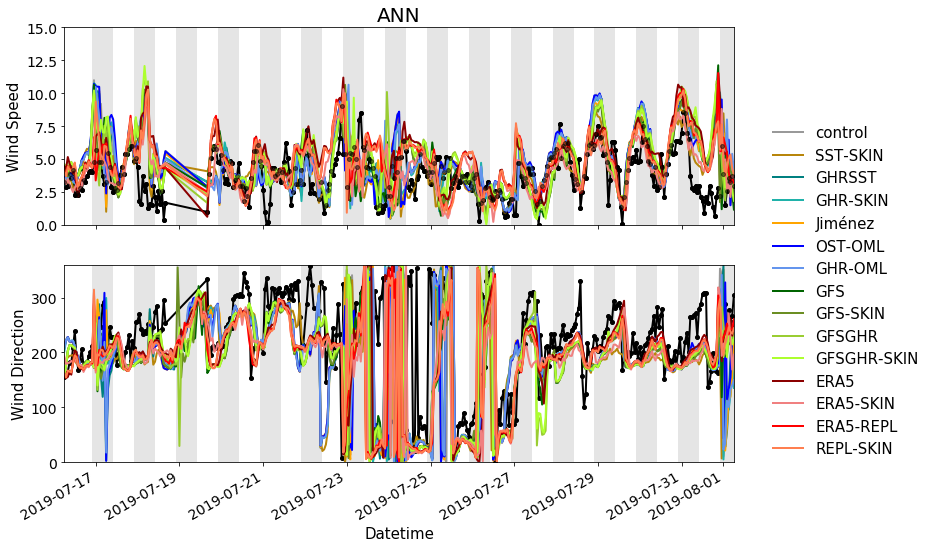

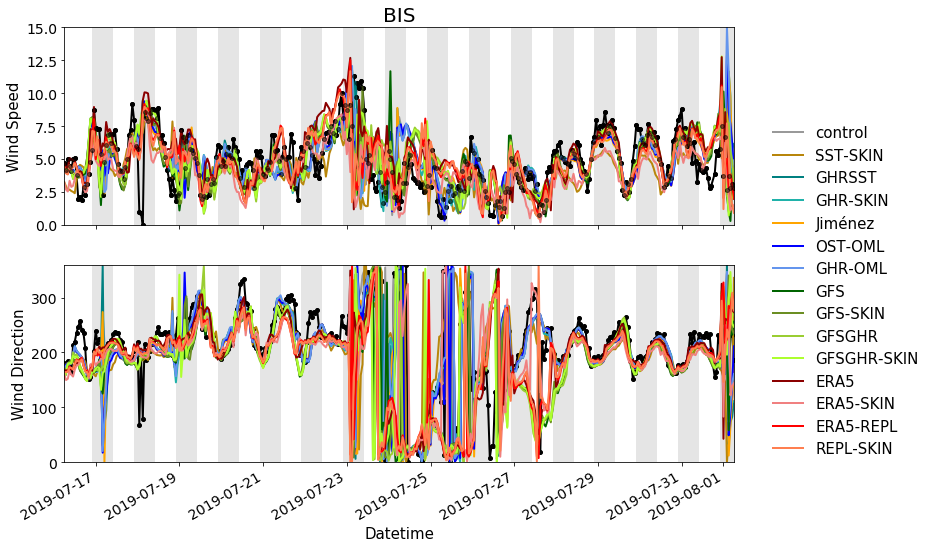

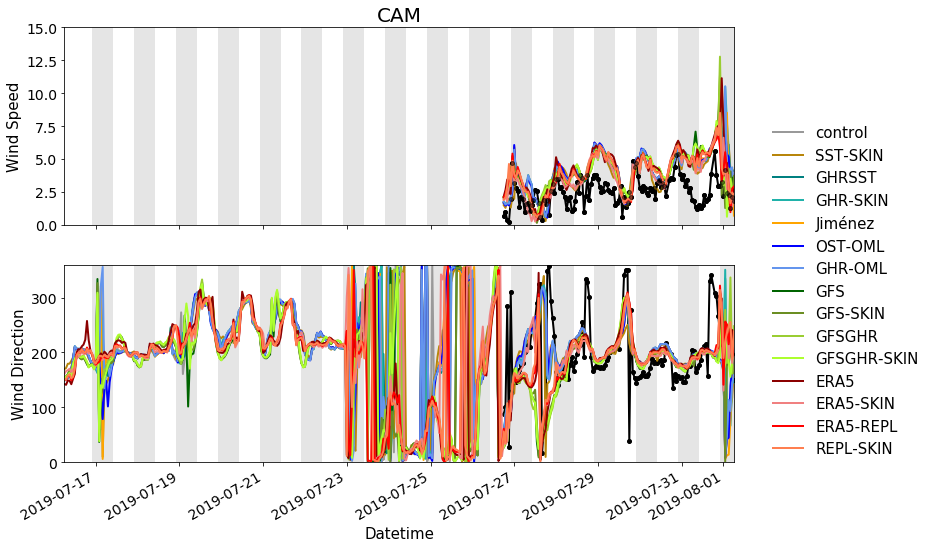

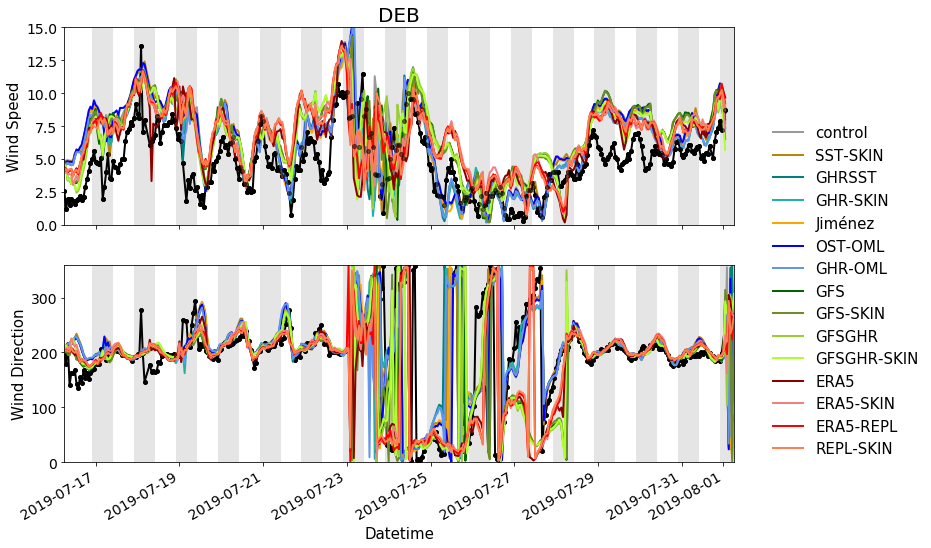

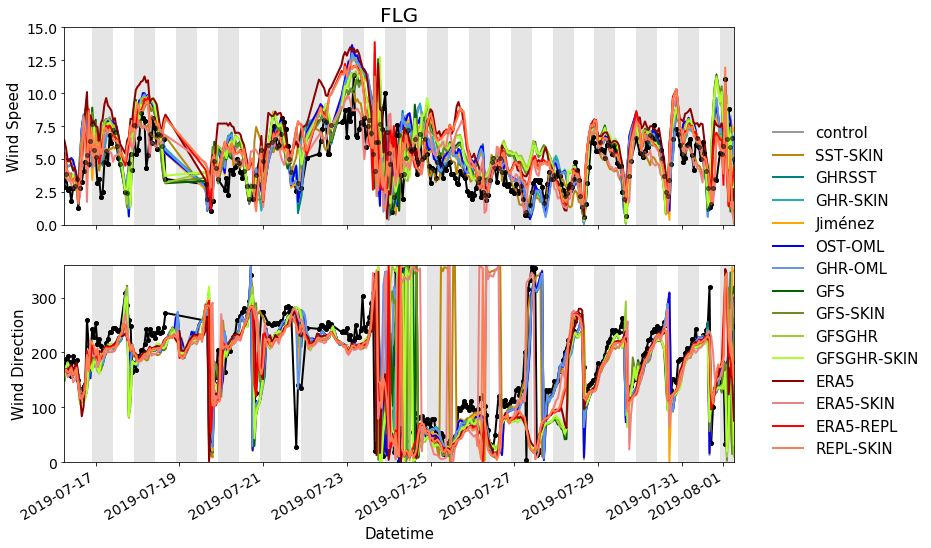

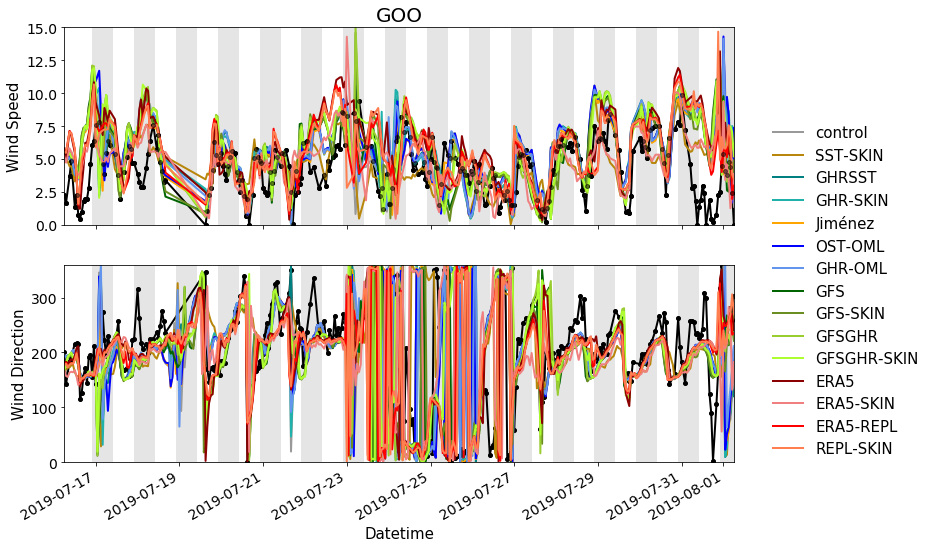

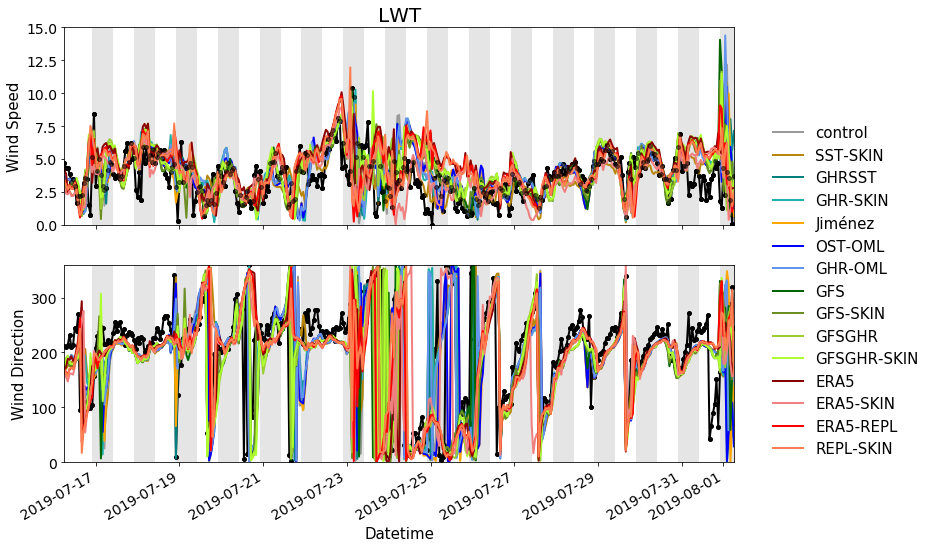

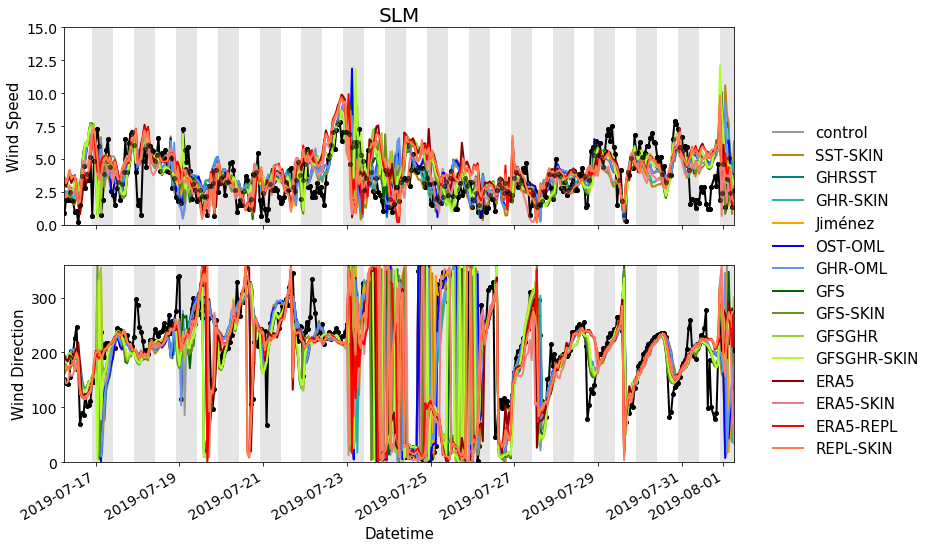

No obs for this station, TBL


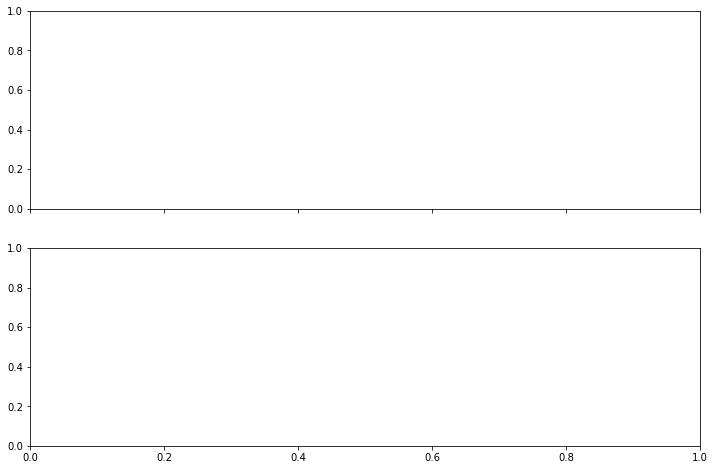

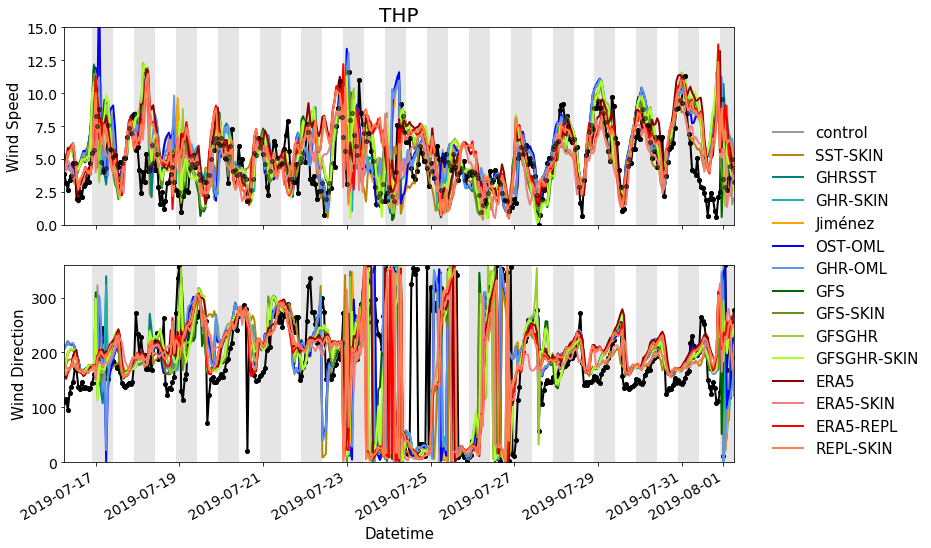

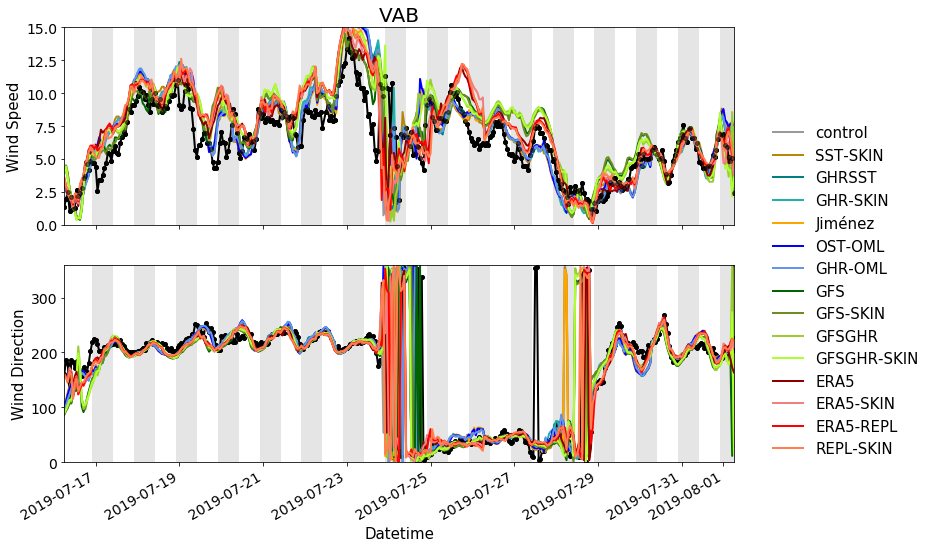

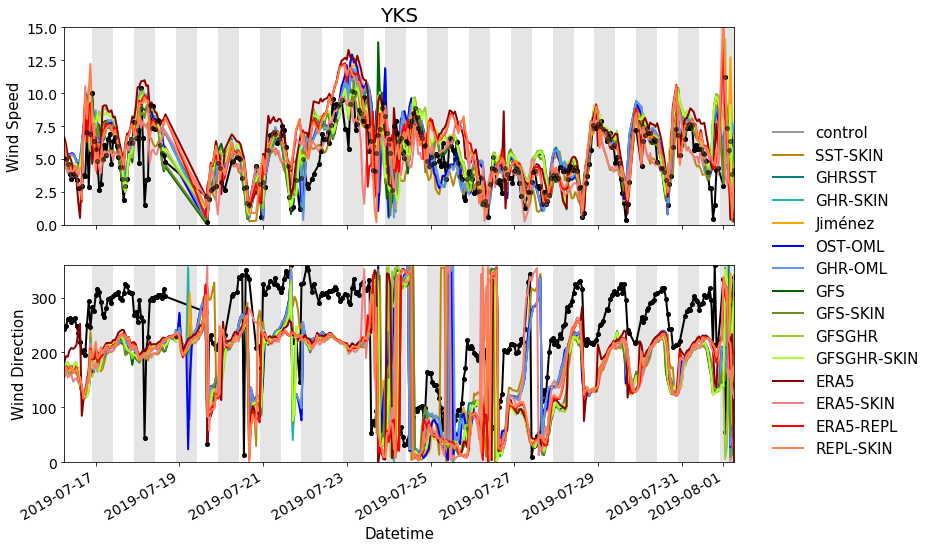

In [91]:
for ss,stn in enumerate(buoy_list):
    fig,ax = plt.subplots(nrows=2,figsize=(12,8),sharex=True)

    sst_obs = obs_res.sel(station=stn).wspd.dropna(how='all',dim='datetime')
    no_obs = False
    if len(sst_obs) > 1:
        sst_obs.plot(ax=ax[0],lw=0.0,c='k',marker='o',markersize=4,zorder=3,alpha=0.5)
        sst_obs.plot(ax=ax[0],lw=2.0,c='k',marker='o',markersize=4)
    else:
        print('No obs for this station, {}'.format(stn))
        no_obs = True
    
    temp_obs = obs_res.sel(station=stn).wdir.dropna(how='all',dim='datetime')
    if len(temp_obs) > 1:
        temp_obs.plot(ax=ax[1],lw=2.0,c='k',marker='o',markersize=4)
        max_t = np.nanmax(temp_obs)
        min_t = np.nanmin(temp_obs)
    else:
        max_t = 40
        min_t = 10
    if not no_obs:
        for cc,case in enumerate(cases_of_interest):

            stn_ds = wrf_buoys_res['{}_{}'.format(case,'d0{}'.format(doms_of_interest[cc]))].sel(station=stn)
            case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]

            # ============================================= #
            # ============= SST PLOT =============== #
            sst_wrf = stn_ds.wspd.dropna(how='all',dim='datetime')
            sst_wrf.plot(ax=ax[0],label='{}'.format(case_plt_dict['name']),
                          c=case_plt_dict['color'],lw=2.0)#,ls=case_style[cc])


            # ============================================= #
            # ============ TEMPERATURE PLOT =============== #
            temp_wrf = stn_ds.wdir.dropna(how='all',dim='datetime')
            temp_wrf.plot(ax=ax[1],label='{}'.format(case_plt_dict['name']),
                          c=case_plt_dict['color'],lw=2.0)#,ls=case_style[cc])

            max_t0 = np.nanmax(temp_wrf)
            min_t0 = np.nanmin(temp_wrf)

            if max_t0 > max_t: max_t = max_t0
            if min_t0 < min_t: min_t = min_t0
        try:
            if np.nanmax(temp_obs) > max_t: max_t = np.nanmax(temp_obs)
        except:
            max_t = max_t
        # ----------- SST Adjustments ------------ #

        plt_start_date = pd.to_datetime(obs_res.datetime.values[0])
        plt_end_date = pd.to_datetime(obs_res.datetime.values[-1])
        for day in pd.date_range(start=plt_start_date, end=plt_end_date):
            night_s = pd.to_datetime('{}-{}-{} 22:00'.format(day.year,day.month,day.day))
            night_e = pd.to_datetime('{}-{}-{} 10:00'.format(day.year,day.month,day.day)) + pd.Timedelta(1,'d')
            for axi in range(0,2):
                #print('start: {}, end: {}'.format(night_s,night_e))
                ax[axi].fill_betweenx([-100,400],night_s,night_e,facecolor='k',alpha=0.1)
        #ax[0].axhline(5.0,t_s,t_e)
        ax[1].legend(frameon=False,fontsize=15,loc=[1.05,0.0],ncol=1)

        #ax[0].axhline(1.5,0,13,c='k',alpha=0.25)
        ax[0].set_title(stn,size=20)
        ax[0].set_xlabel('')
        ax[0].tick_params(labelsize=14)
        ax[0].set_ylabel('Wind Speed',size=15)
        ax[0].set_ylim(0,15)
        ax[0].set_xlim(t_s,t_e)
        leg_loc = 0.89


        # --------- Temperature Adjustments --------- #
        ax[1].set_ylim(0,360)
        ax[1].set_xlim(obs_res.datetime.values[0],obs_res.datetime.values[-1])
        ax[1].set_title('')
        ax[1].tick_params(labelsize=14)
        ax[1].set_ylabel('Wind Direction',size=15)
        ax[1].set_xlabel('Datetime',size=15)
        #ax[1].set_ylim(5,45)
        # -------------------------------------------- #
        plt.show()


# Taylor Diagrams

In [97]:
remove_mean = False

remove_low_wspds = False
wspd_cutoff = 1.4

remove_night = True
night_hour_s = 23
night_hour_e = 14

only_observed_bb_days = False

save_figs   = False


TD_stns = list(buoy_list.copy())

TD_stns.remove('DEB')
TD_stns.remove('VAB')
TD_stns.remove('SLM')
TD_stns.remove('THP')

markers = [(i,j,0) for i in np.arange(2,len(cases)*2) for j in range(1, 2)]
markers = ['o','^','P','X','D','p','d','h','v']

bb_observed_dates = {'StaufferThompson2015': {  '2019-07-01' : ['NAK'],
                                                '2019-07-09' : ['MTN', 'NAK'],
                                                '2019-07-10' : ['NUI'],
                                                '2019-07-11' : ['NAK'],
                                                '2019-07-15' : ['MTN', 'NAK'],
                                                '2019-07-16' : ['NHK'],
                                                '2019-07-17' : ['NAK'],
                                                '2019-07-19' : ['MTN'],
                                                '2019-07-20' : ['MTN'],
                                                '2019-07-24' : ['NUI'],
                                                '2019-07-26' : ['BWI', 'MTN', 'NAK'],
                                                '2019-07-27' : ['MTN', 'NHK'],
                                                '2019-07-28' : ['NAK', 'NHK'],
                                                '2019-07-29' : ['MTN', 'NAK', 'NHK'],
                                                '2019-07-31' : ['NAK', 'NHK']},
                             'Stauffer2015': {  '2019-07-01' : ['NAK'],
                                                '2019-07-07' : ['NHK'],
                                                '2019-07-09' : ['NAK'],
                                                '2019-07-16' : ['NHK'],
                                                '2019-07-27' : ['NAK', 'NHK'],
                                                '2019-07-28' : ['NAK', 'NHK'],
                                                '2019-07-29' : ['NAK', 'NHK'],
                                                '2019-07-30' : ['NAK'],
                                                '2019-07-31' : ['NAK', 'NHK']},
                               'Sikora2010': {  '2019-07-16' : ['NHK'],
                                                '2019-07-27' : ['NHK'],
                                                '2019-07-28' : ['NAK'],
                                                '2019-07-31' : ['NAK', 'NHK']}
                    }


bay_breeze_days_from_obs = []
for meth in bb_observed_dates:
    meth_dates = bb_observed_dates[meth]
    for date in meth_dates:
        bay_breeze_days_from_obs.append(date)
    
bay_breeze_days_from_obs = list(np.unique(bay_breeze_days_from_obs))

#bay_breeze_days_from_obs = ['2019-07-09','2019-07-10','2019-07-11','2019-07-15',
#                            '2019-07-16','2019-07-17','2019-07-19','2019-07-20',
#                            '2019-07-24','2019-07-26','2019-07-27','2019-07-28',
#                            '2019-07-29','2019-07-31']

TD_start = '2019-07-19 00:00:00'
TD_end   = '2019-07-21 00:00:00'

TD_start = t_s
TD_end   = t_e

In [98]:
TD_obs_full = {}
for ss,stn in enumerate(TD_stns):
    temp_obs_ds = obs_res.sel(station=stn).copy()
    for var in vars_to_compare:
        obs_var = var
        temp_obs_ds.drop_vars(obs_var)
        obs = obs_res.sel(station=stn)[obs_var].copy()

        if obs_var == 'wdir':
            obs = np.cos(np.radians(270. - obs))*np.sin(np.radians(270. - obs))
            obs_var = 'wdirA'
            
        if remove_night:
            for day in pd.date_range(start=plt_start_date, end=plt_end_date):
                night_s = pd.to_datetime('{0}-{1}-{2} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_s))
                night_e = pd.to_datetime('{0}-{1}-{2} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_e)) + pd.Timedelta(1,'d')
                obs.sel(datetime=slice(night_s,night_e)).data[:] = obs.sel(datetime=slice(night_s,night_e)).data*np.nan   
                
        if only_observed_bb_days:
            for day in pd.date_range(start=plt_start_date, end=plt_end_date):
                day_str = '{0}-{1:02d}-{2:02d}'.format(day.year,day.month,day.day)
                if day_str not in bay_breeze_days_from_obs:
                    day_s = pd.to_datetime(day_str)
                    day_e = day_s + pd.Timedelta(1,'d')
                    obs.sel(datetime=slice(day_s,day_e)).data[:] = obs.sel(datetime=slice(day_s,day_e)).data*np.nan
        temp_obs_ds[obs_var] = obs
        
    TD_obs_full[stn] = temp_obs_ds
    

TD_wrf_buoys = {}
for cc,case in enumerate(cases_of_interest):

    temp_twr_ds = wrf_buoys_res['{}_{}'.format(case,'d0{}'.format(doms_of_interest[cc]))].copy()

    for vv,var in enumerate(vars_to_compare):
        obs_var = var
        sim_var = vars_to_compare[var]

        if var != 'wdir':
            temp_twr_ds = temp_twr_ds.drop_vars(sim_var)
        
        temp_var = wrf_buoys_res['{}_{}'.format(case,'d0{}'.format(doms_of_interest[cc]))][sim_var].copy()
        
        for ss,stn in enumerate(TD_stns):
            
            td_var = temp_var.sel(station=stn)

            obs = TD_obs_full[stn][obs_var]
                        
            if var == 'wdir':
                td_var = np.cos(np.radians(270. - td_var))*np.sin(np.radians(270. - td_var))
                sim_var = 'wdirA'
            td_var[np.where(np.isnan(obs))] = np.nan

            if remove_mean: td_var = td_var - td_var(temp_var,2016/32,0)
                           
            temp_var.sel(station=stn).data[:] = td_var.data[:]

        temp_twr_ds[sim_var] = temp_var
    TD_wrf_buoys[case] = temp_twr_ds


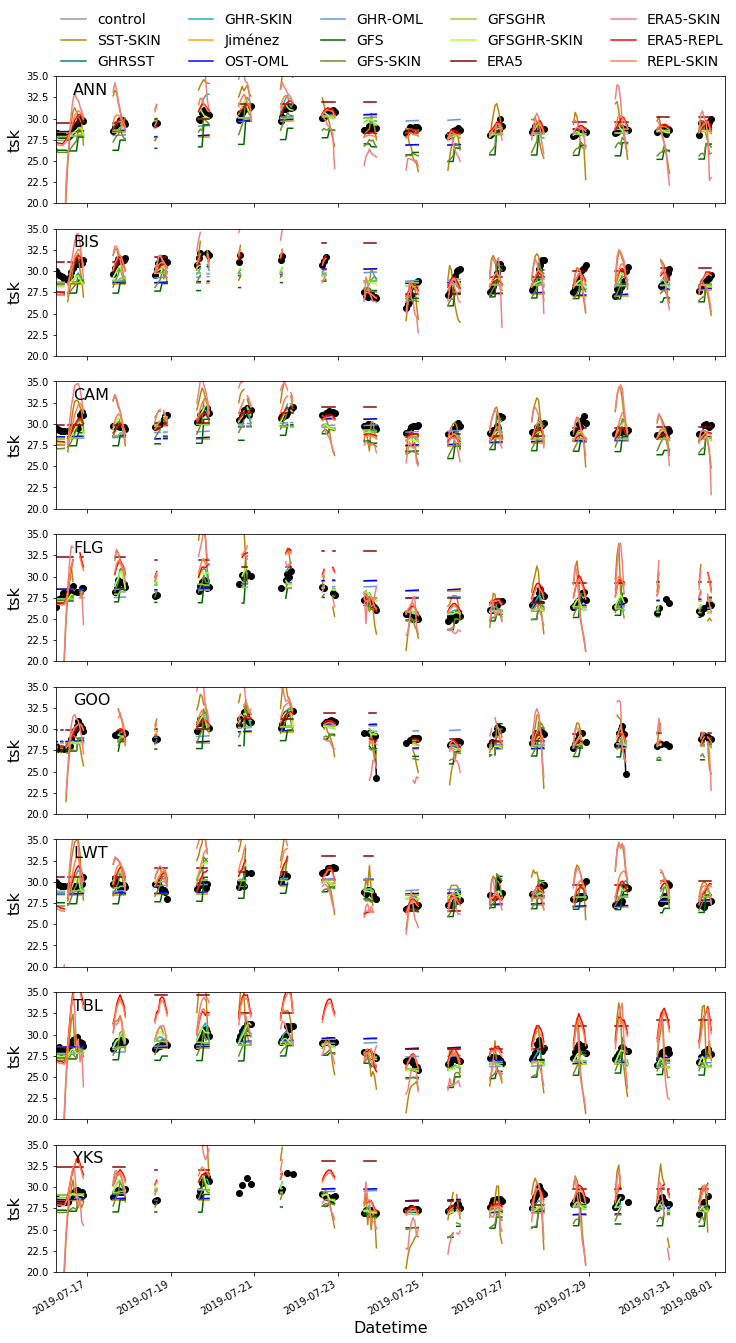

/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


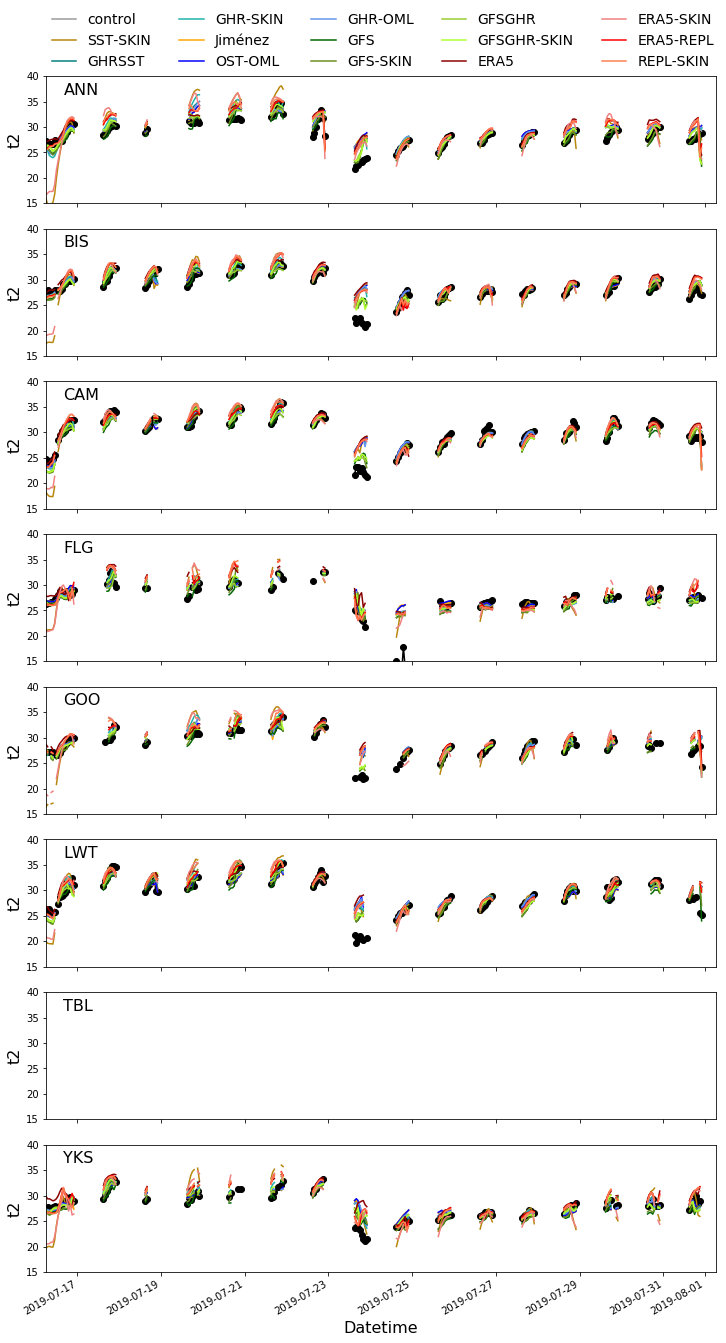

/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


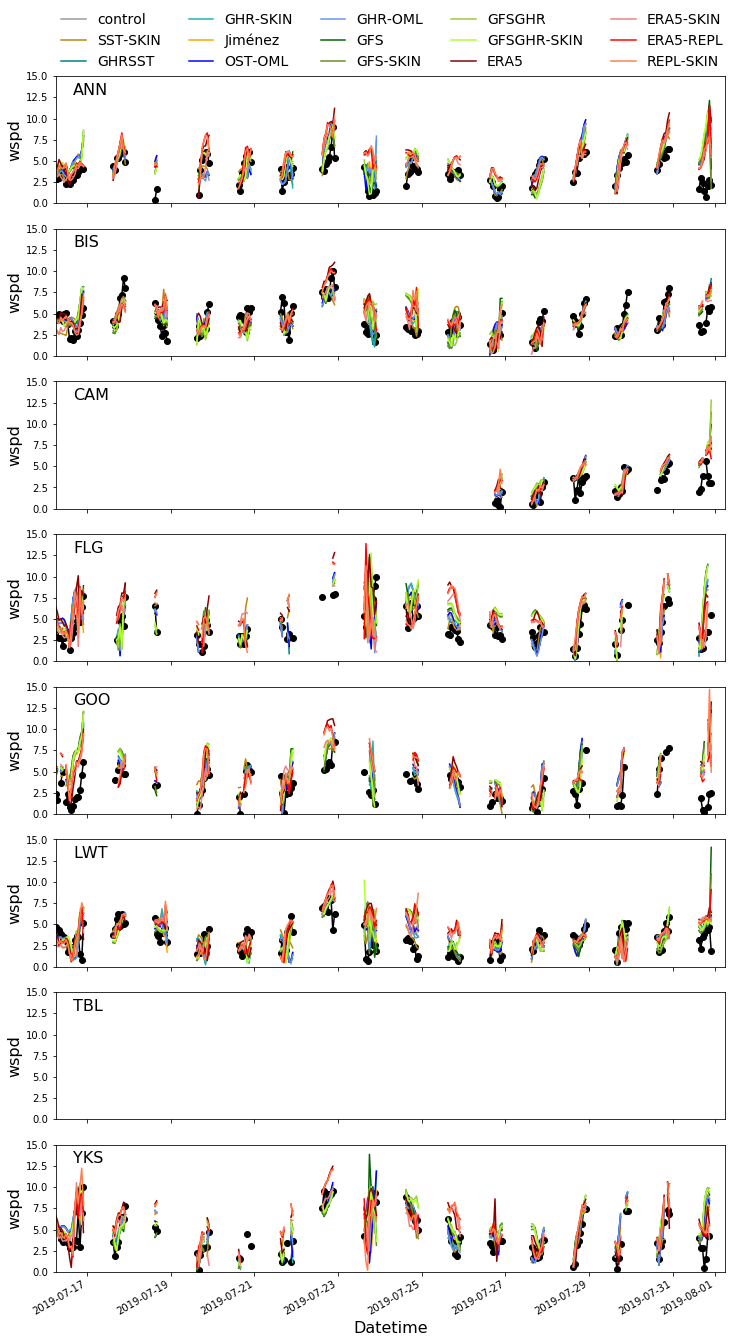

In [99]:
for var in vars_to_compare:
    if var != 'wdir':
        obs_var = var
        sim_var = vars_to_compare[var]
    else:
        obs_var = '{}A'.format(var)
        sim_var = '{}A'.format(vars_to_compare[var])
    
    fig,ax = plt.subplots(len(TD_stns),sharex=True,figsize=(12,22))
    for ss,stn in enumerate(TD_stns):

        obs = TD_obs_full[stn][obs_var]


        ref_std = np.std(obs.dropna(how='any',dim='datetime').data)

        for cc,case in enumerate(cases_of_interest):
            case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
            sim = TD_wrf_buoys[case][sim_var].sel(station=stn)
            
            if cc == 0:
                obs_plt = obs#.dropna(how='any',dim='datetime')
                if len(obs.dropna(how='any',dim='datetime')) > 2:
                    obs_plt.plot(ax=ax[ss],c='k',marker='o')
            if len(sim.dropna(how='any',dim='datetime')) > 2:
                sim_plt = sim#.dropna(how='any',dim='datetime')
                sim_plt.plot(ax=ax[ss],label='{}'.format(case_plt_dict['name']),c=case_plt_dict['color'])

        ax[ss].set_ylabel(sim_var,size=16)
        if ss == len(TD_stns) - 1:
            ax[ss].set_xlabel('Datetime',size=16)
        else:
            ax[ss].set_xlabel('')
        if ss == 0:
            ax[ss].set_title(var,size=18)
        else:
            ax[ss].set_title('')
        
        if var == 'wspd':
            ymin,ymax = 0,15
        if var == 'wdir':
            ymin,ymax = 0,0.5
        if var == 'sst':
            ymin,ymax = 20,35
        if var == 'temp':
            ymin,ymax = 15,40
        if var == 'u':
            ymin,ymax = -10,10
        if var == 'v':
            ymin,ymax = -10,10
            
        ax[ss].set_ylim(ymin,ymax)

        ax[ss].set_xlim(sim.datetime.data[0],sim.datetime.data[-1])
        ax[ss].text(sim.datetime.data[10],ymax - 0.05*(ymax-ymin),stn,va='top',ha='left',size=16)
    ax[0].legend(frameon=False,ncol=5,loc=(0.0,1.01),fontsize=14,handlelength=1.75)
    ax[0].set_title('')
    plt.show()
 

## TD diagrams by station

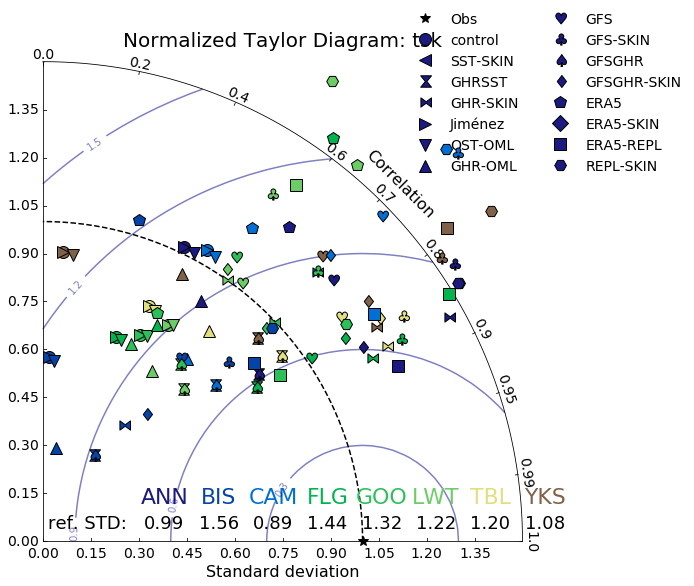

/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/nu

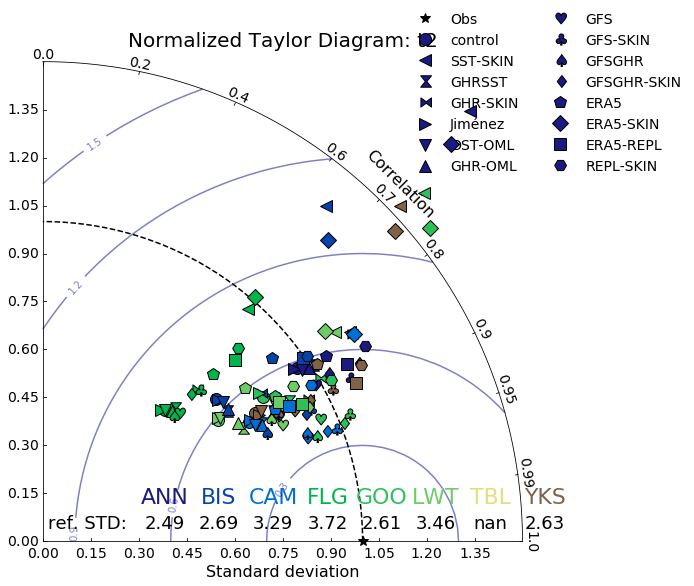

/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/nu

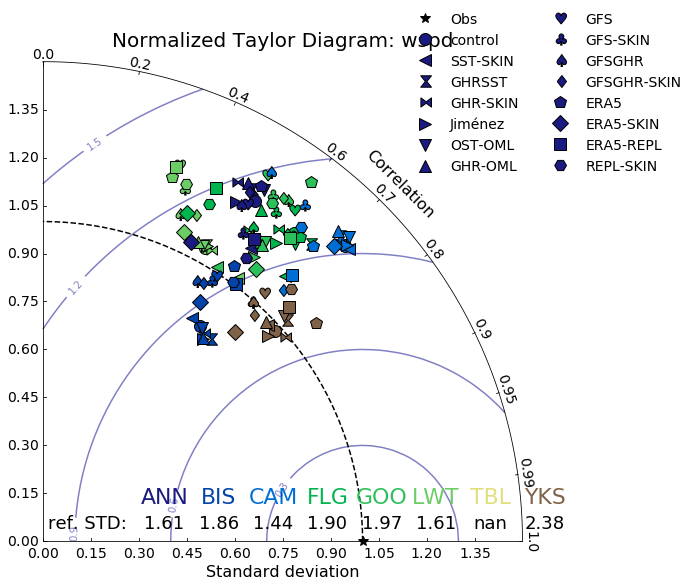

In [100]:
for var in vars_to_compare:
    if var != 'wdir':
        obs_var = var
        sim_var = vars_to_compare[var]
    else:
        obs_var = '{}A'.format(var)
        sim_var = '{}A'.format(vars_to_compare[var])
    
    fig_tay = plt.figure(figsize=(9,9))    
    dia = TaylorDiagram(1.0, fig=fig_tay, extend=False,label='Obs',srange=[0.0,1.50])
    for ss,stn in enumerate(TD_stns):

        obs = TD_obs_full[stn][obs_var]
        obs = obs.dropna(how='any',dim='datetime')
        ref_std = np.std(obs.data)
        
        for cc,case in enumerate(cases_of_interest):
            case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
            sim = TD_wrf_buoys[case][sim_var].sel(station=stn)
            sim = sim.dropna(how='any',dim='datetime')
            if ss == 0: 
                #label_str = '_'.join(case.replace('_KF','').split('_')[1:])
                label_str = case_plt_dict['name']
            else:
                label_str = None
            #print(case,stn,np.std(sim.data)/ref_std)
            if case_plt_dict['fill']:
                marker_c = stn_colors[stn]
                marker_e = 'k'
            else:
                marker_c = stn_colors[stn]
                marker_e = stn_colors[stn]
            dia.add_sample(np.std(sim.data)/ref_std, np.corrcoef(sim,obs)[0,1],
                           marker=case_plt_dict['marker'], ms=12, ls='',
                           mfc=marker_c, mec=marker_e, # Colors
                           label=label_str,
                           zorder=cc)

            
        txt_x = 0.38 + 0.17*ss
        txt_y = 0.12
        plt.text(txt_x,txt_y,'{0}'.format(stn),c=stn_colors[stn],size=22,ha='center')
        plt.text(txt_x,txt_y-0.08,'{0:2.2f}'.format(ref_std),size=18,ha='center')
        if ss == 0: plt.text(txt_x-0.1,txt_y-0.08,'ref. STD: ',size=18,ha='right')    
            

    contours = dia.add_contours(levels=5, colors='darkblue',alpha=0.5)
    dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
    plt.legend(frameon=False,fontsize=14,loc=(0.75,0.75),ncol=2)
    plt.title('Normalized Taylor Diagram: {}'.format(sim_var),size=20,y=1.01)
    plt.show()
        

## TD diagrams averaged over stations

    'The ‘‘mean model’’ statistics are calculated after regridding each model’s output to a common (T42) grid, and then computing the multimodel mean value at each grid cell.'
    
- https://www.earth.ox.ac.uk/~yvesp/teaching/TiO_climate_models/Gleckler_et_al_2008.pdf

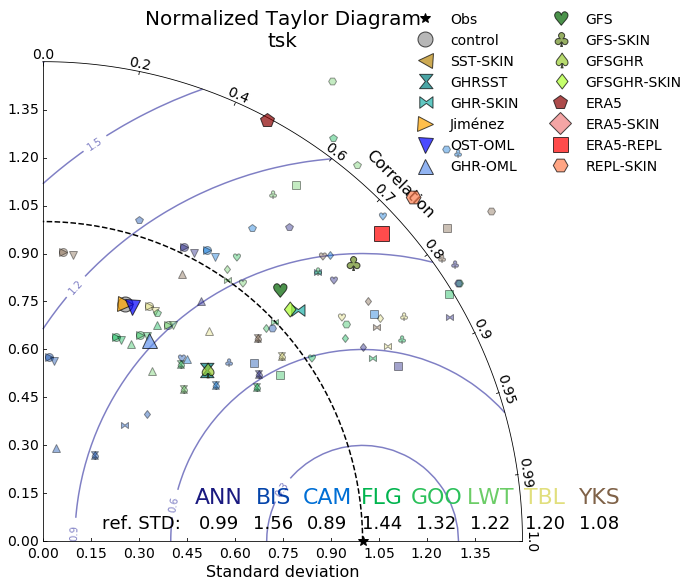

/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/glade/u/home/hawb

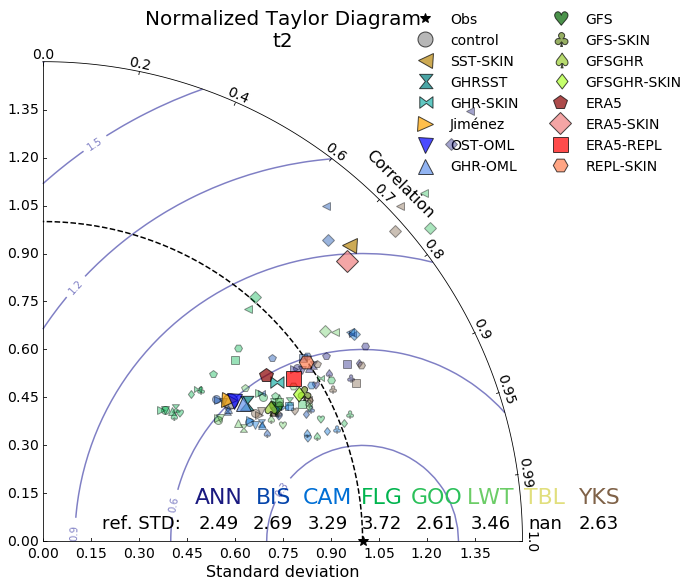

/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/glade/u/home/hawb

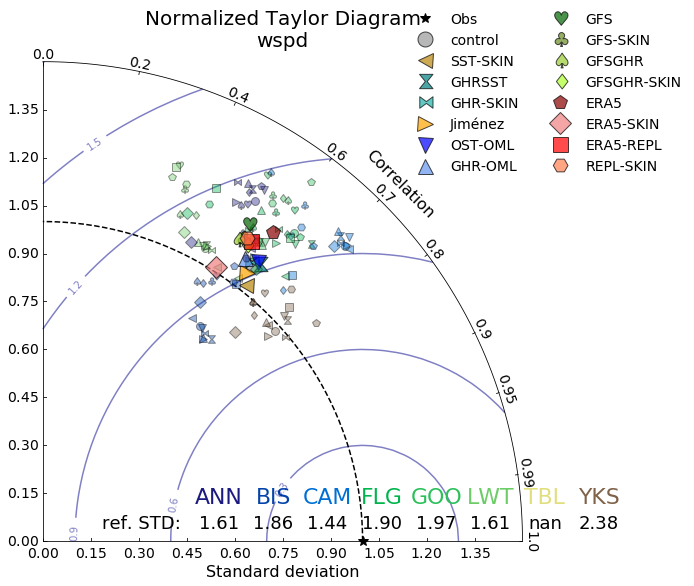

In [101]:
for var in vars_to_compare:
    if var != 'wdir':
        obs_var = var
        sim_var = vars_to_compare[var]
    else:
        obs_var = '{}A'.format(var)
        sim_var = '{}A'.format(vars_to_compare[var])
    
    fig_tay = plt.figure(figsize=(9,9))    
    dia = TaylorDiagram(1.0, fig=fig_tay, extend=False,label='Obs',srange=[0.0,1.50])
    sum_norm_std = 0
    sum_norm_cc  = 0
    stn_count    = 0
    
    for cc,case in enumerate(cases_of_interest):
        case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]

        for ss,stn in enumerate(TD_stns):
            if stn != 'GRF':

                obs = TD_obs_full[stn][obs_var]
                obs = obs.dropna(how='any',dim='datetime')

                ref_std = np.std(obs.data)


                sim = TD_wrf_buoys[case][sim_var].sel(station=stn)
                sim = sim.dropna(how='any',dim='datetime')
                if ss == 0: 
                    obs_full = obs - np.nanmean(obs)
                    sim_full = sim - np.nanmean(sim)
                    #label_str = '_'.join(case.replace('_KF','').split('_')[1:])
                    label_str = None
                else:
                    obs_full = np.concatenate([obs_full,obs - np.nanmean(obs)])
                    sim_full = np.concatenate([sim_full,sim - np.nanmean(sim)])
                    label_str = None
                #print(case,stn,np.std(sim.data)/ref_std)
                if case_plt_dict['fill']:
                    marker_c = stn_colors[stn]
                    marker_e = 'k'
                else:
                    marker_c = stn_colors[stn]
                    marker_e = stn_colors[stn]
                sum_norm_std += np.std(sim.data)/ref_std
                sum_norm_cc  += np.corrcoef(sim,obs)[0,1]
                stn_count += 1

                dia.add_sample(np.std(sim.data)/ref_std, np.corrcoef(sim,obs)[0,1],
                               marker=case_plt_dict['marker'], ms=8, ls='',
                               mfc=marker_c, mec=marker_e, # Colors
                               label=label_str,
                               zorder=cc,alpha=0.4)

                if cc == 0:
                    txt_x = 0.38 + 0.17*stn_count
                    txt_y = 0.12
                    plt.text(txt_x,txt_y,'{0}'.format(stn),c=stn_colors[stn],size=22,ha='center')
                    plt.text(txt_x,txt_y-0.08,'{0:2.2f}'.format(ref_std),size=18,ha='center')
                    if ss == 0: plt.text(txt_x-0.1,txt_y-0.08,'ref. STD: ',size=18,ha='right')

            multimodal_mean = True
        
        if multimodal_mean:
            ref_std_full = np.std(obs_full)

            dia.add_sample(np.std(sim_full)/ref_std_full, np.corrcoef(sim_full,obs_full)[0,1],
                   marker=case_plt_dict['marker'], ms=15, ls='',
                   mfc=case_plt_dict['color'], mec='k', # Colors
                   label=case_plt_dict['name'],
                   zorder=cc+3,alpha=0.7)
        else:        
            dia.add_sample(sum_norm_std/stn_count, sum_norm_cc/stn_count,
                   marker=case_plt_dict['marker'], ms=15, ls='',
                   mfc=case_plt_dict['color'], mec='k', # Colors
                   label=case_plt_dict['name'],
                   zorder=cc+3,alpha=0.7)
    contours = dia.add_contours(levels=5, colors='darkblue',alpha=0.5,zorder=1)
    dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
    plt.legend(frameon=False,fontsize=14,loc=(0.75,0.75),ncol=2)
    plt.title('Normalized Taylor Diagram\n{}'.format(sim_var),size=20,y=1.01)
    plt.show()
    
    
        

In [102]:
def create_2dHistogram(varA,varB,n_binsA,n_binsB):
    '''
    Returns the x, y, and z arrays to plot a 2-D histogram
    given two variables, A (x-axis) and B (y-axis).
    To call:
    x,y,z = create_2dHistogram(variableA,variableB,number_of_bins)
    To plot, call:
    plt.pcolormesh(x,y, z,norm=colors.LogNorm(vmin=1e-2,vmax=hist2d.max()))
    '''
    varA_flat = varA.flatten()
    varB_flat = varB.flatten()
    varA_vs_varB, ab_xedges, ab_yedges = np.histogram2d(varA_flat, varB_flat, bins=[n_binsA,n_binsB])
    x_2d, y_2d = np.meshgrid(ab_xedges,ab_yedges)
    return(x_2d,y_2d,varA_vs_varB.T)

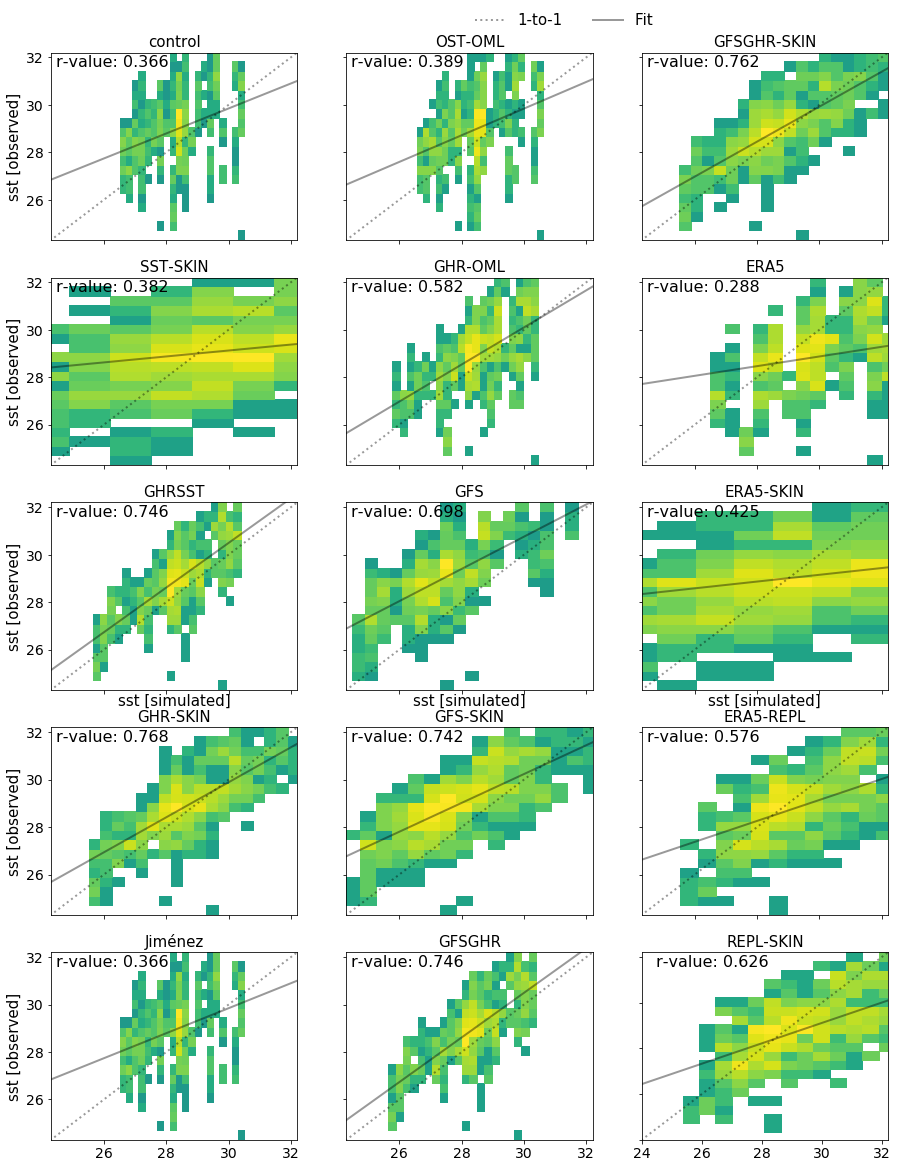

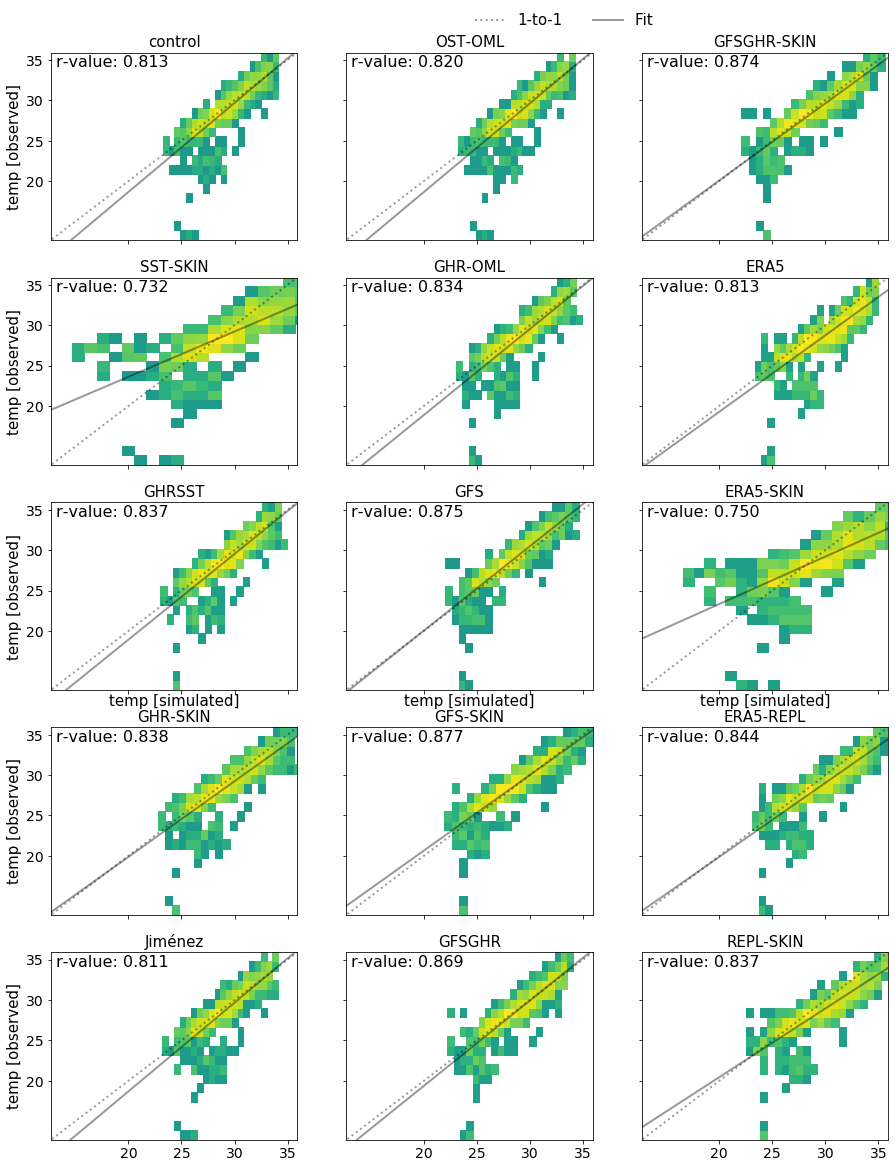

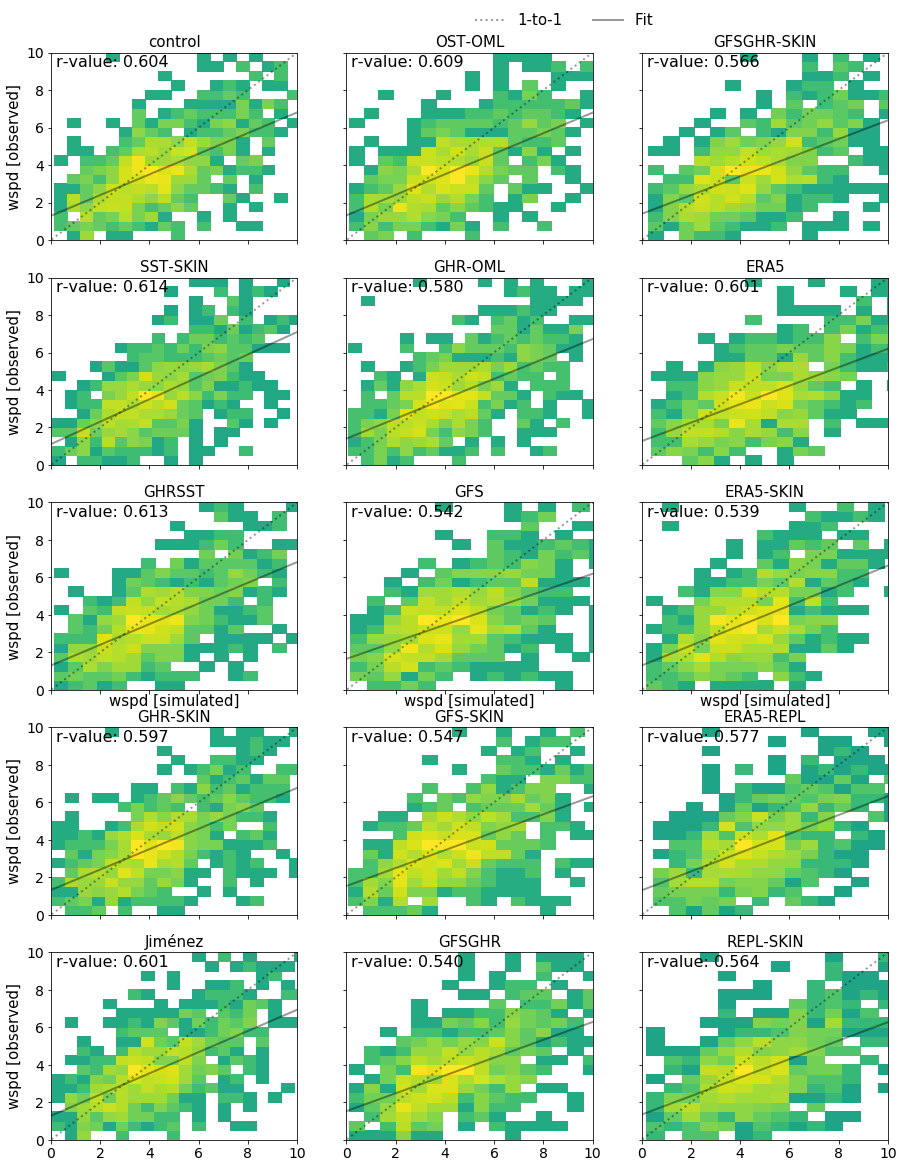

In [114]:
for var in vars_to_compare:
    obs_var = var
    sim_var = vars_to_compare[var]
    fig,ax = plt.subplots(nrows=5,ncols=3,figsize=(15,20),sharey=True,sharex=True)
    row = 0
    col = 0
    for cc,case in enumerate(cases_of_interest):
        for ss,stn in enumerate(TD_stns):
            if stn == 'GRF':# and var == 'sst':
                print('skipping {} for GRF'.format(var))
                varA = []
                varB = []
            else:
                obs = TD_obs_full[stn][obs_var]
                obs = obs.dropna(how='any',dim='datetime')

                case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
                sim = TD_wrf_buoys[case][sim_var].sel(station=stn)
                sim = sim.dropna(how='any',dim='datetime')

                varA = sim.data
                varB = obs.data
            
            if ss == 0:
                varA_f = varA
                varB_f = varB
            else:
                varA_f = np.concatenate((varA_f,varA))
                varB_f = np.concatenate((varB_f,varB))
        if (len(varA_f) == len(varB_f)) and (len(varA_f) > 2):
            slope, intercept, r_value, p_value, std_err = stats.linregress(varA_f, varB_f)
            x2d,y2d,hist2d = create_2dHistogram(varA_f,varB_f,20,20)

            ax[row,col].pcolormesh(x2d,y2d, hist2d,norm=colors.LogNorm(vmin=1e-2,vmax=hist2d.max()))
            #plt.colorbar()
            if col == 0: ax[row,col].set_ylabel('{} [observed]'.format(var),size=15)
            if row == 2: ax[row,col].set_xlabel('{} [simulated]'.format(var),size=15)
            ref_x = np.arange(-1000,1001)
            if cc == 0:
                line_lbl1 = '1-to-1'
                line_lbl2 = 'Fit'
            else:
                line_lbl1 = None
                line_lbl2 = None
            ax[row,col].plot(ref_x,ref_x,c='k',lw=2.0,alpha=0.4,ls=':',label=line_lbl1)
            ax[row,col].plot(ref_x,slope*ref_x + intercept,c='k',lw=2.0,alpha=0.4,label=line_lbl2)
            if cc == 0: ax[0,0].legend(frameon=False,loc=(1.7,1.1),fontsize=15,ncol=2)
            xmin,xmax = (np.nanmin(x2d),np.nanmax(x2d))
            ymin,ymax = (np.nanmin(y2d),np.nanmax(y2d))
            if var == 'wdir':
                ymin,ymax = 0,360

            ax[row,col].set_xlim(ymin,ymax)
            ax[row,col].set_ylim(ymin,ymax)
            ax[row,col].text(ymin+0.02*(ymax-ymin),ymin+0.99*(ymax-ymin),'r-value: {0:4.3f}'.format(r_value),size=16,va='top')
            ax[row,col].set_title(case_plt_dict['name'],size=15)
            ax[row,col].tick_params(labelsize=14)
            if var == 'sst':
                tick_min,tick_max,tick_int = 24,32,2
            elif var == 'temp':
                tick_min,tick_max,tick_int = 20,35,5
            elif var == 'wspd':
                tick_min,tick_max,tick_int = 0,10,2
            elif var == 'wdir':
                tick_min,tick_max,tick_int = 0,360,90
            elif var == 'u' or var == 'v':
                tick_min,tick_max,tick_int = -5,5,5

            ax[row,col].set_xticks(np.arange(tick_min,tick_max+1,tick_int))
            ax[row,col].set_yticks(np.arange(tick_min,tick_max+1,tick_int))
            row += 1
            if row == 5:
                row = 0
                col += 1
    plt.show()
    print()
    print()
    
                
        

In [29]:
vars_to_compare2 = {'wspd':'wspd','u':'u','v':'v'}
var_colors = {'wspd':'b','u':'g','v':'r'}

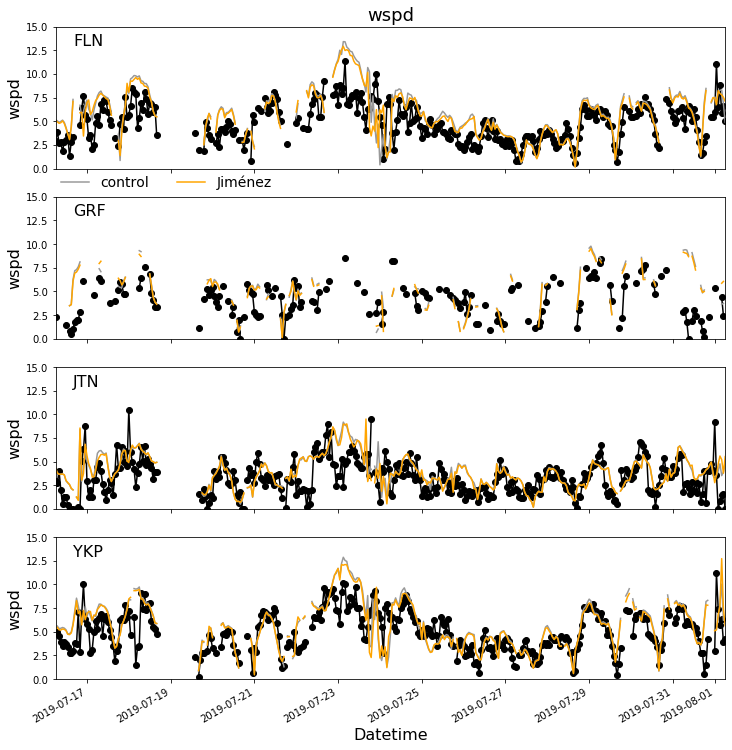

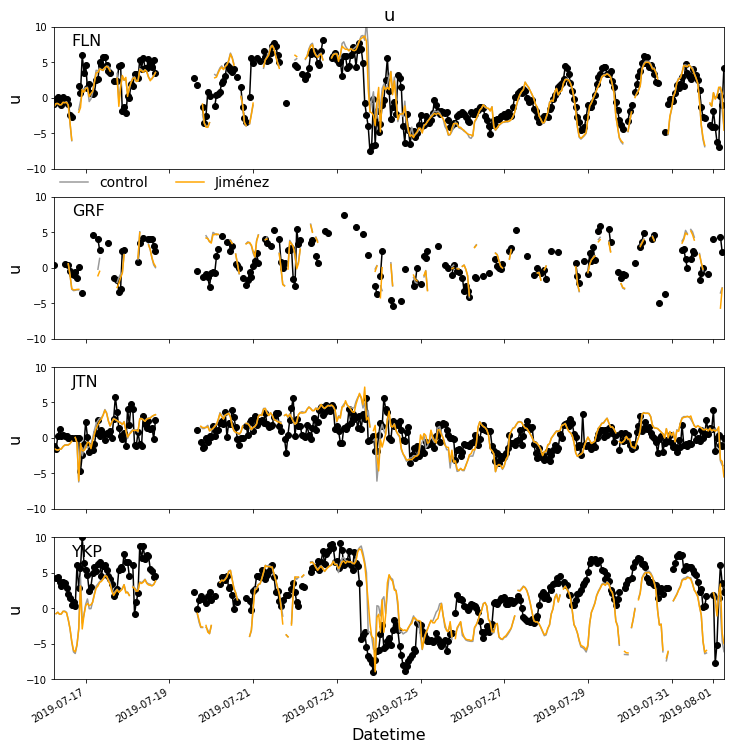

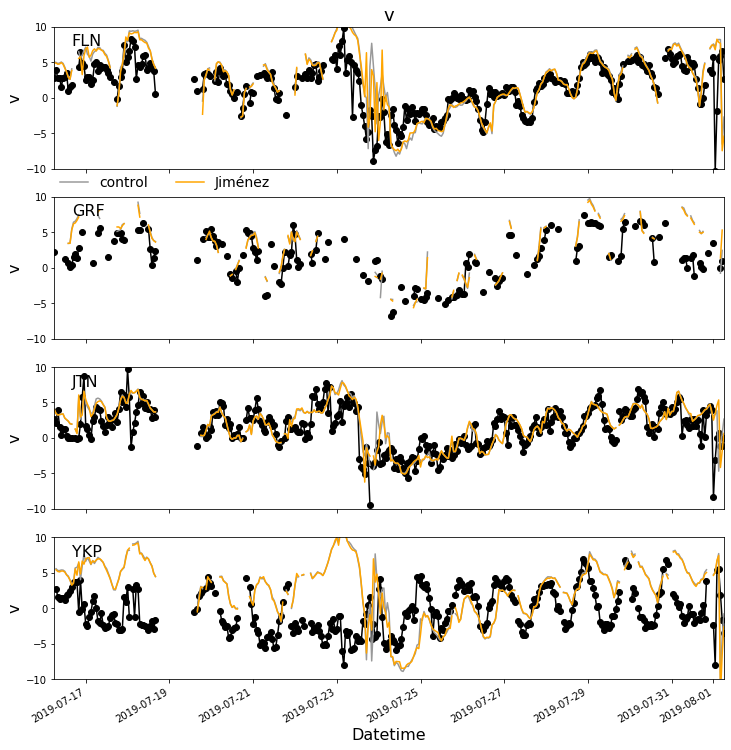

In [30]:
for var in vars_to_compare2:
    obs_var = var
    sim_var = vars_to_compare2[var]
    
    fig,ax = plt.subplots(len(TD_stns),sharex=True,figsize=(12,12))
    for ss,stn in enumerate(TD_stns):

        obs = TD_obs_full[stn][obs_var]


        ref_std = np.std(obs.dropna(how='any',dim='datetime').data)

        for cc,case in enumerate(cases_of_interest):
            case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
            sim = TD_wrf_buoys[case][sim_var].sel(station=stn)
            
            if cc == 0:
                obs_plt = obs#.dropna(how='any',dim='datetime')
                if len(obs.dropna(how='any',dim='datetime')) > 2:
                    obs_plt.plot(ax=ax[ss],c='k',marker='o')
            if len(sim.dropna(how='any',dim='datetime')) > 2:
                sim_plt = sim#.dropna(how='any',dim='datetime')
                sim_plt.plot(ax=ax[ss],label='{}'.format(case_plt_dict['name']),c=case_plt_dict['color'])

        ax[ss].set_ylabel(sim_var,size=16)
        if ss == len(TD_stns) - 1:
            ax[ss].set_xlabel('Datetime',size=16)
        else:
            ax[ss].set_xlabel('')
        if ss == 0:
            ax[ss].set_title(var,size=18)
        else:
            ax[ss].set_title('')
        
        if var == 'wspd':
            ymin,ymax = 0,15
        if var == 'wdir':
            ymin,ymax = 0,0.5
        if var == 'sst':
            ymin,ymax = 20,35
        if var == 'temp':
            ymin,ymax = 15,40
        if var == 'u':
            ymin,ymax = -10,10
            
        ax[ss].set_ylim(ymin,ymax)

        ax[ss].set_xlim(sim.datetime.data[0],sim.datetime.data[-1])
        ax[ss].text(sim.datetime.data[10],ymax - 0.05*(ymax-ymin),stn,va='top',ha='left',size=16)
    ax[1].legend(frameon=False,ncol=5,loc=(0.,1.01),fontsize=14)
    plt.show()
 

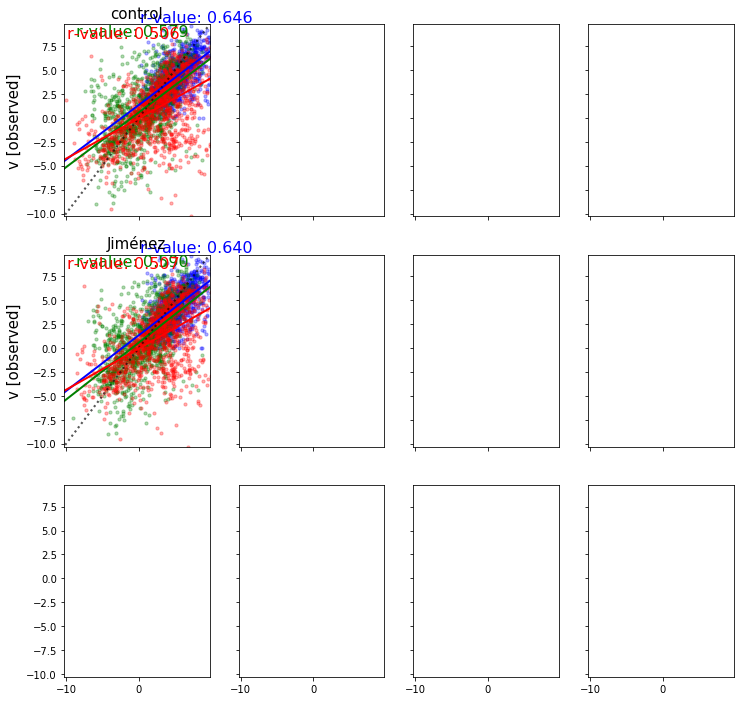

In [31]:
fig,ax = plt.subplots(nrows=3,ncols=4,figsize=(12,12),sharey=True,sharex=True)
for var in vars_to_compare2:
    obs_var = var
    sim_var = vars_to_compare2[var]
    row = 0
    col = 0
    for cc,case in enumerate(cases_of_interest):
        for ss,stn in enumerate(TD_stns):
            if stn == 'GRF' and var == 'sst':
                varA = []
                varB = []
            else:
                obs = TD_obs_full[stn][obs_var]
                obs = obs.dropna(how='any',dim='datetime')

                case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
                sim = TD_wrf_buoys[case][sim_var].sel(station=stn)
                sim = sim.dropna(how='any',dim='datetime')

                varA = sim.data
                varB = obs.data
            
            if ss == 0:
                varA_f = varA
                varB_f = varB
            else:
                varA_f = np.concatenate((varA_f,varA))
                varB_f = np.concatenate((varB_f,varB))
        if (len(varA_f) == len(varB_f)) and (len(varA_f) > 2):
            slope, intercept, r_value, p_value, std_err = stats.linregress(varA_f, varB_f)

            ax[row,col].scatter(varA_f,varB_f,s=10,c=var_colors[var],alpha=0.3)
            if col == 0: ax[row,col].set_ylabel('{} [observed]'.format(var),size=15)
            if row == 2: ax[row,col].set_xlabel('{} [simulated]'.format(var),size=15)

            ref_x = np.arange(-1000,1001)
            ax[row,col].plot(ref_x,ref_x,c='k',lw=2.0,alpha=0.3,ls=':')
            ax[row,col].plot(ref_x,slope*ref_x + intercept,lw=2.0,c=var_colors[var])
            xmin,xmax = (np.nanmin(varA_f),np.nanmax(varA_f))
            ymin,ymax = (np.nanmin(varB_f),np.nanmax(varB_f))
            ax[row,col].set_xlim(ymin,ymax)
            ax[row,col].set_ylim(ymin,ymax)
            ax[row,col].text(ymin+0.02*(ymax-ymin),ymin+0.99*(ymax-ymin),'r-value: {0:4.3f}'.format(r_value),size=16,va='top',c=var_colors[var])
            ax[row,col].set_title(case_plt_dict['name'],size=15)
            row += 1
            if row == 3:
                row = 0
                col += 1
plt.show()
print()
print()

        

# WRF Fields

### Read in WRF output at location of buoys

In [12]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

starting CBB_2019071518


/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: No contour levels were found within the data range.
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: No contour levels were found within the data range.


ANN 38.976086 -76.43796 0.0 17.0 4.265625
FLN 37.000824 -76.0751 0.0 17.0 7.799156
GRF 38.54394 -76.41293 0.0 17.0 13.6328125
JTN 37.199356 -76.781006 0.0 17.0 8.042781
PMC 38.029922 -76.32153 0.0 17.0 5.0286503
SRP 37.570366 -76.26416 0.0 17.0 6.5097656
YKP 37.192806 -76.27319 0.0 17.0 10.263532


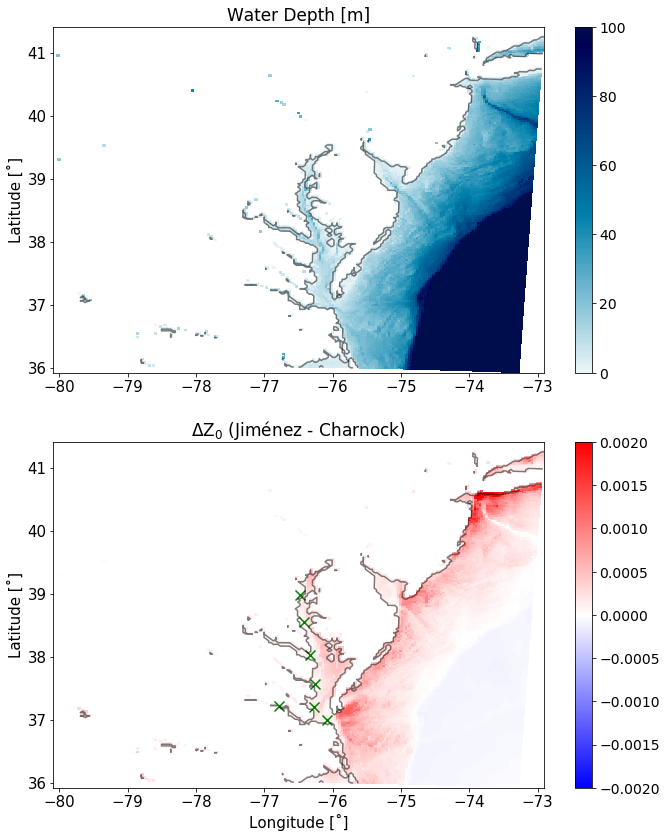

In [16]:
fig,ax = plt.subplots(nrows=2,figsize=(11,14))
print('starting {}'.format(restarts[0]))
dom = 3
f_list1 = sorted(glob.glob('{}{}/{}/wrfout_d0{}*'.format(wrf_dir,'ERAI_YSU_CHRN_OST_NOSK_4DOM',restarts[0],dom)))
f_list2 = sorted(glob.glob('{}{}/{}/wrfout_d0{}*'.format(wrf_dir,'ERAI_YSU_JMNZ_OST_NOSK_3DOM',restarts[0],dom)))
f_list2 = sorted(glob.glob('{}test/{}/wrfout_d0{}*'.format(wrf_dir,restarts[0],dom)))
wrf_loc_dict = {}

wrf_chrn = Dataset(f_list1[-10])
wrf_jmnz = Dataset(f_list2[-10])

znt_chrn = wrf_chrn.variables['ZNT'][0,:,:]
znt_jmnz = wrf_jmnz.variables['ZNT'][0,:,:]

water_depth = wrf_jmnz.variables['WATER_DEPTH'][0,:,:]

wrf_chrn.close()
wrf_jmnz.close()

wrf_i = Dataset('{}/wrfinput_d0{}'.format('/'.join(f_list1[0].split('/')[:-1]),dom))
lat = wrf_i.variables['XLAT'][0,:,:]
lon = wrf_i.variables['XLONG'][0,:,:]
landmask = wrf_i.variables['LANDMASK'][0,:,:]

water_depth[np.where(landmask==1.0)] = np.nan
znt_chrn[np.where(landmask==1.0)] = np.nan
znt_jmnz[np.where(landmask==1.0)] = np.nan

water_plt  = ax[0].pcolormesh(lon,lat,water_depth,norm=Normalize(0,100),cmap=truncate_colormap(plt.cm.ocean_r,0.025,0.7))
water_cbar = plt.colorbar(water_plt,ax=ax[0])
water_cbar.ax.tick_params(labelsize=14)

diff_plt  = ax[1].pcolormesh(lon,lat,znt_jmnz-znt_chrn,norm=Normalize(-0.002,0.002),cmap=plt.cm.bwr)
diff_cbar = plt.colorbar(diff_plt,ax=ax[1])
diff_cbar.ax.tick_params(labelsize=14)

ax[0].contour(lon,lat,landmask,levels=[1.0],colors='k',alpha=0.5)
ax[1].contour(lon,lat,landmask,levels=[1.0],colors='k',alpha=0.5)
ax[0].tick_params(labelsize=15)
ax[1].tick_params(labelsize=15)

ax[0].set_ylabel('Latitude [˚]',size=15)
ax[1].set_ylabel('Latitude [˚]',size=15)
ax[1].set_xlabel('Longitude [˚]',size=15)

ax[0].set_title('Water Depth [m]',size=17)
ax[1].set_title('$\Delta$Z$_0$ (Jiménez - Charnock)',size=17)

for ss,stn in enumerate(buoy_loc_dict):
    wrf_loc_dict[stn] = {}
    loc_x,loc_y = wrf.ll_to_xy(wrf_i,buoy_loc_dict[stn]['lat'],buoy_loc_dict[stn]['lon'])
    loc_x = int(loc_x.data)
    loc_y = int(loc_y.data)
    if stn == 'ANN':loc_x += 1

    wrf_loc_dict[stn]['x'] = loc_x
    wrf_loc_dict[stn]['y'] = loc_y

    wrf_lat = wrf_i.variables['XLAT'][0,loc_y,loc_x]
    wrf_lon = wrf_i.variables['XLONG'][0,loc_y,loc_x]
    lmask = wrf_i.variables['LANDMASK'][0,loc_y,loc_x]
    lui   = wrf_i.variables['LU_INDEX'][0,loc_y,loc_x]
    print(stn,wrf_lat,wrf_lon,lmask,lui,water_depth[loc_y,loc_x])
    if lmask == 1:
        mc = 'r'
    else:
        mc = 'g'
    ax[1].scatter(buoy_loc_dict[stn]['lon'],buoy_loc_dict[stn]['lat'],marker='x',s=100,c=mc)
    #plt.scatter(wrf_lon,wrf_lat,marker='o',s=100,c='None',edgecolors='k')
    #plt.text(buoy_loc_dict[stn]['lon'],buoy_loc_dict[stn]['lat'],stn,size=20,va='bottom')

wrf_i.close()
#plt.ylim(36.5,39.5)
#plt.xlim(-78.0,-75)
plt.show()
